# FAANG Forecaster: Apple Stock Price Forecasting

In [1]:
# Impoting Dependencies
from faang_utils import load_data, plot_forecasts, build_pipeline, create_features_labels, evaluate_model_performance
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler, PowerTransformer
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import logging
import pickle
import shutil
import skopt

In [2]:
logging.basicConfig(filename = "../Logs/apple_ml_modeling.log", filemode = "w", format = "%(asctime)s - %(levelname)s - %(message)s", level = logging.INFO)
sns.set(font_scale = 1.5, style = "darkgrid", palette = "bright")
warnings.filterwarnings(action = "ignore")
plt.rcParams["figure.figsize"] = (20, 10)
pd.options.display.max_columns = None
np.random.seed(seed = 42)

Let"s call the function to load the data.

In [3]:
# Calling the function to load the data
ts_df = load_data(ipo_name = "Apple")

# logging information to the log file
logging.info(msg = "Data has been loaded")

# Displaying the first five records
ts_df.head()

,date,target
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862


Let"s visualize the historical stock price of **Apple**.

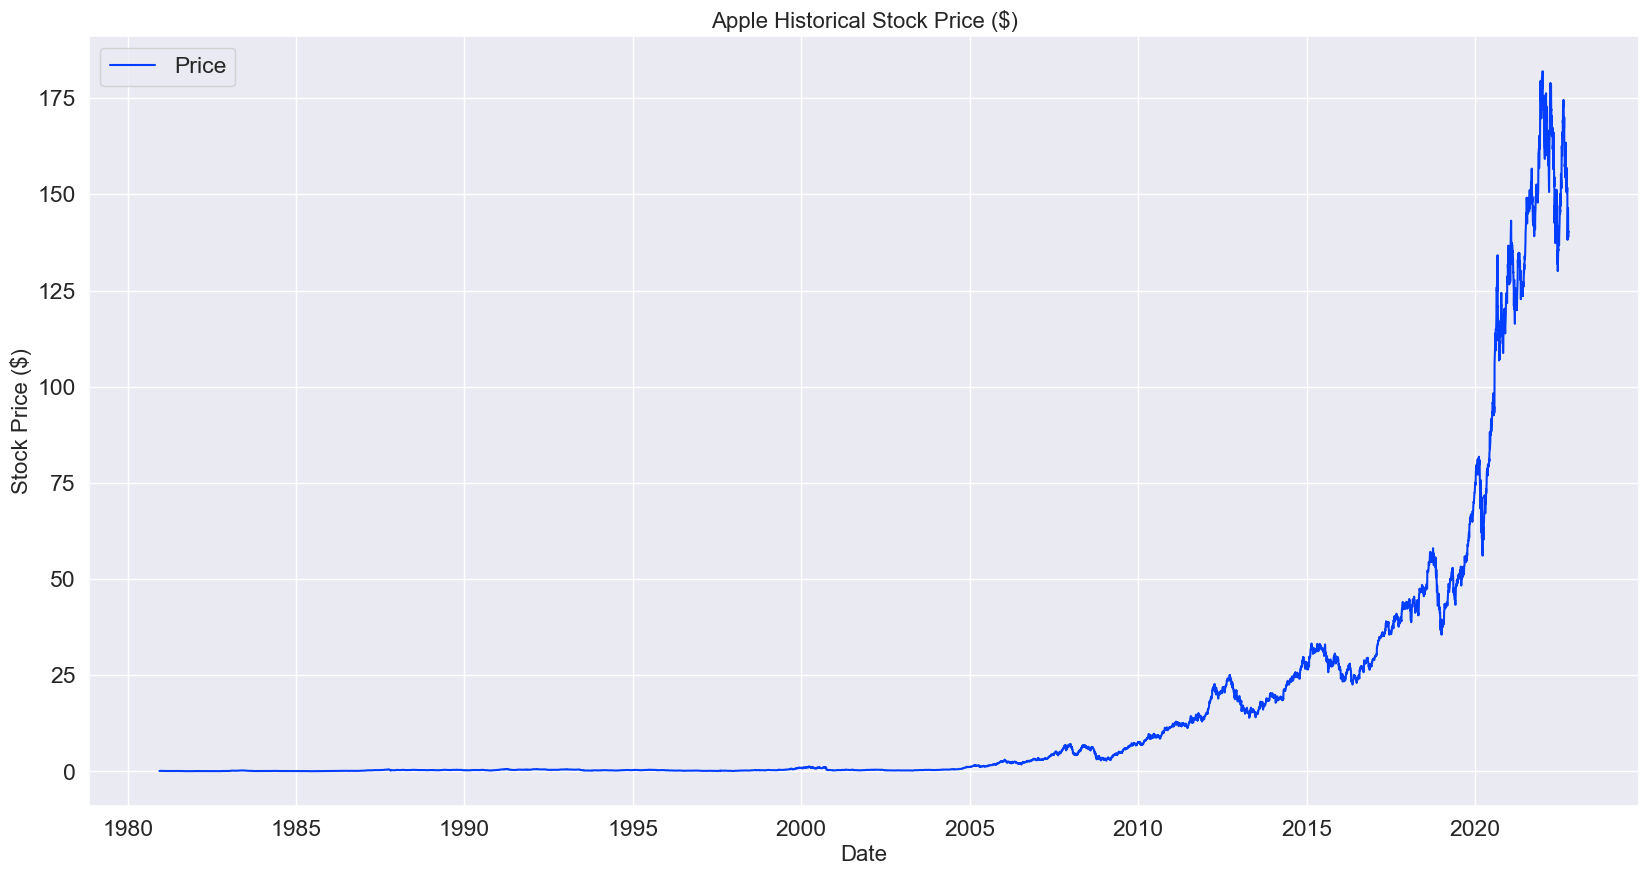

In [4]:
# Visualizing the historical stock price of Apple
plt.plot(ts_df.date, ts_df.target, label = "Price")
plt.title(label = "Apple Historical Stock Price ($)", fontsize = 16)
plt.ylabel(ylabel = "Stock Price ($)", fontsize = 16)
plt.xlabel(xlabel = "Date", fontsize = 16)
plt.legend(loc = "upper left")
plt.show()

Let"s call the function to create features and labels using **sliding window** technique.

In [5]:
# Calling the function to create features and labels
X, Y = create_features_labels(data_frame = ts_df)

# Spliting the features and labels into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = False)

# Displaying the shape of the train & test features and labels
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8416, 21), (8416, 7), (2104, 21), (2104, 7))

Let"s visualize the time series forecasting split.

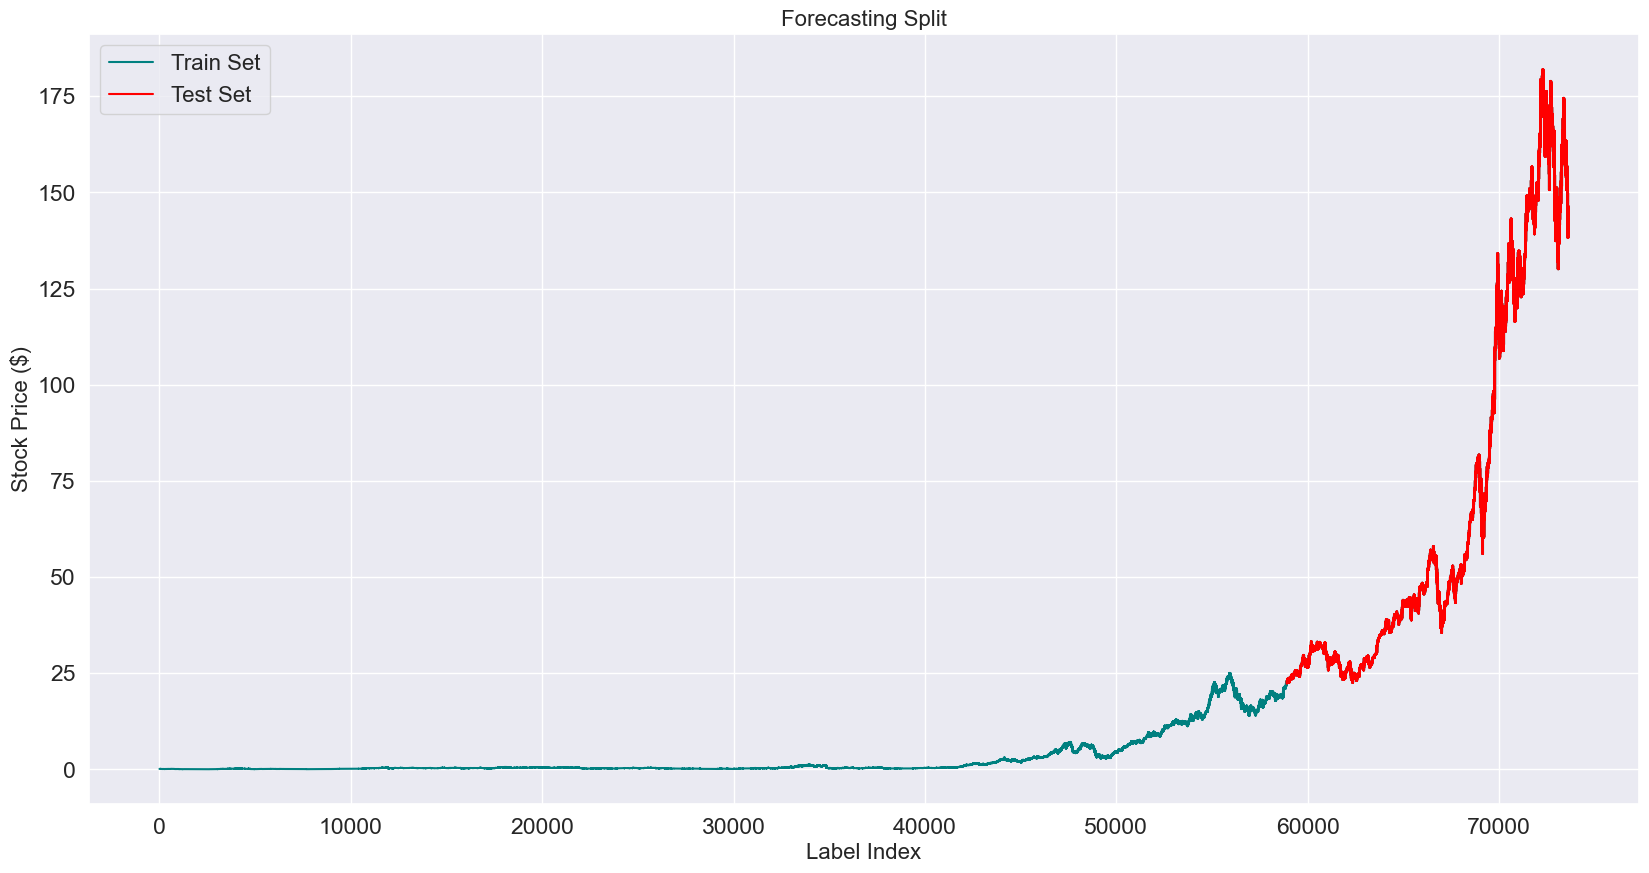

In [6]:
# Horizontally stacking the labels of the train and the test set
stacked_labels = np.hstack(tup = (y_train.ravel(), y_test.ravel()))

# Visualing the time series forecasting split
plt.plot(range(stacked_labels.size), stacked_labels, label = "Train Set", c = "teal")
plt.plot(list(range(stacked_labels.size - y_test.ravel().size, stacked_labels.size)), y_test.ravel(), label = "Test Set", c = "red")
plt.title(label = "Forecasting Split", fontsize = 16)
plt.ylabel(ylabel = "Stock Price ($)", fontsize = 16)
plt.xlabel(xlabel = "Label Index", fontsize = 16)
plt.legend(loc = "upper left", fontsize = 16)
plt.show()

***
### Baseline

Let"s call the function to build a forecasting pipeline.

In [7]:
# Calling the function to the build a forecasting pipeline
baseline_model = build_pipeline(regressor = DummyRegressor(),
                                train_features = X_train, 
                                train_labels = y_train)

# logging information to the log file
logging.info(msg = "Forecaster with Baseline algorithm has been built")

# Displaying the architecture of the regressor
baseline_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor', DummyRegressor())])

Let"s call the function to visually compare forecasts to ground truths.

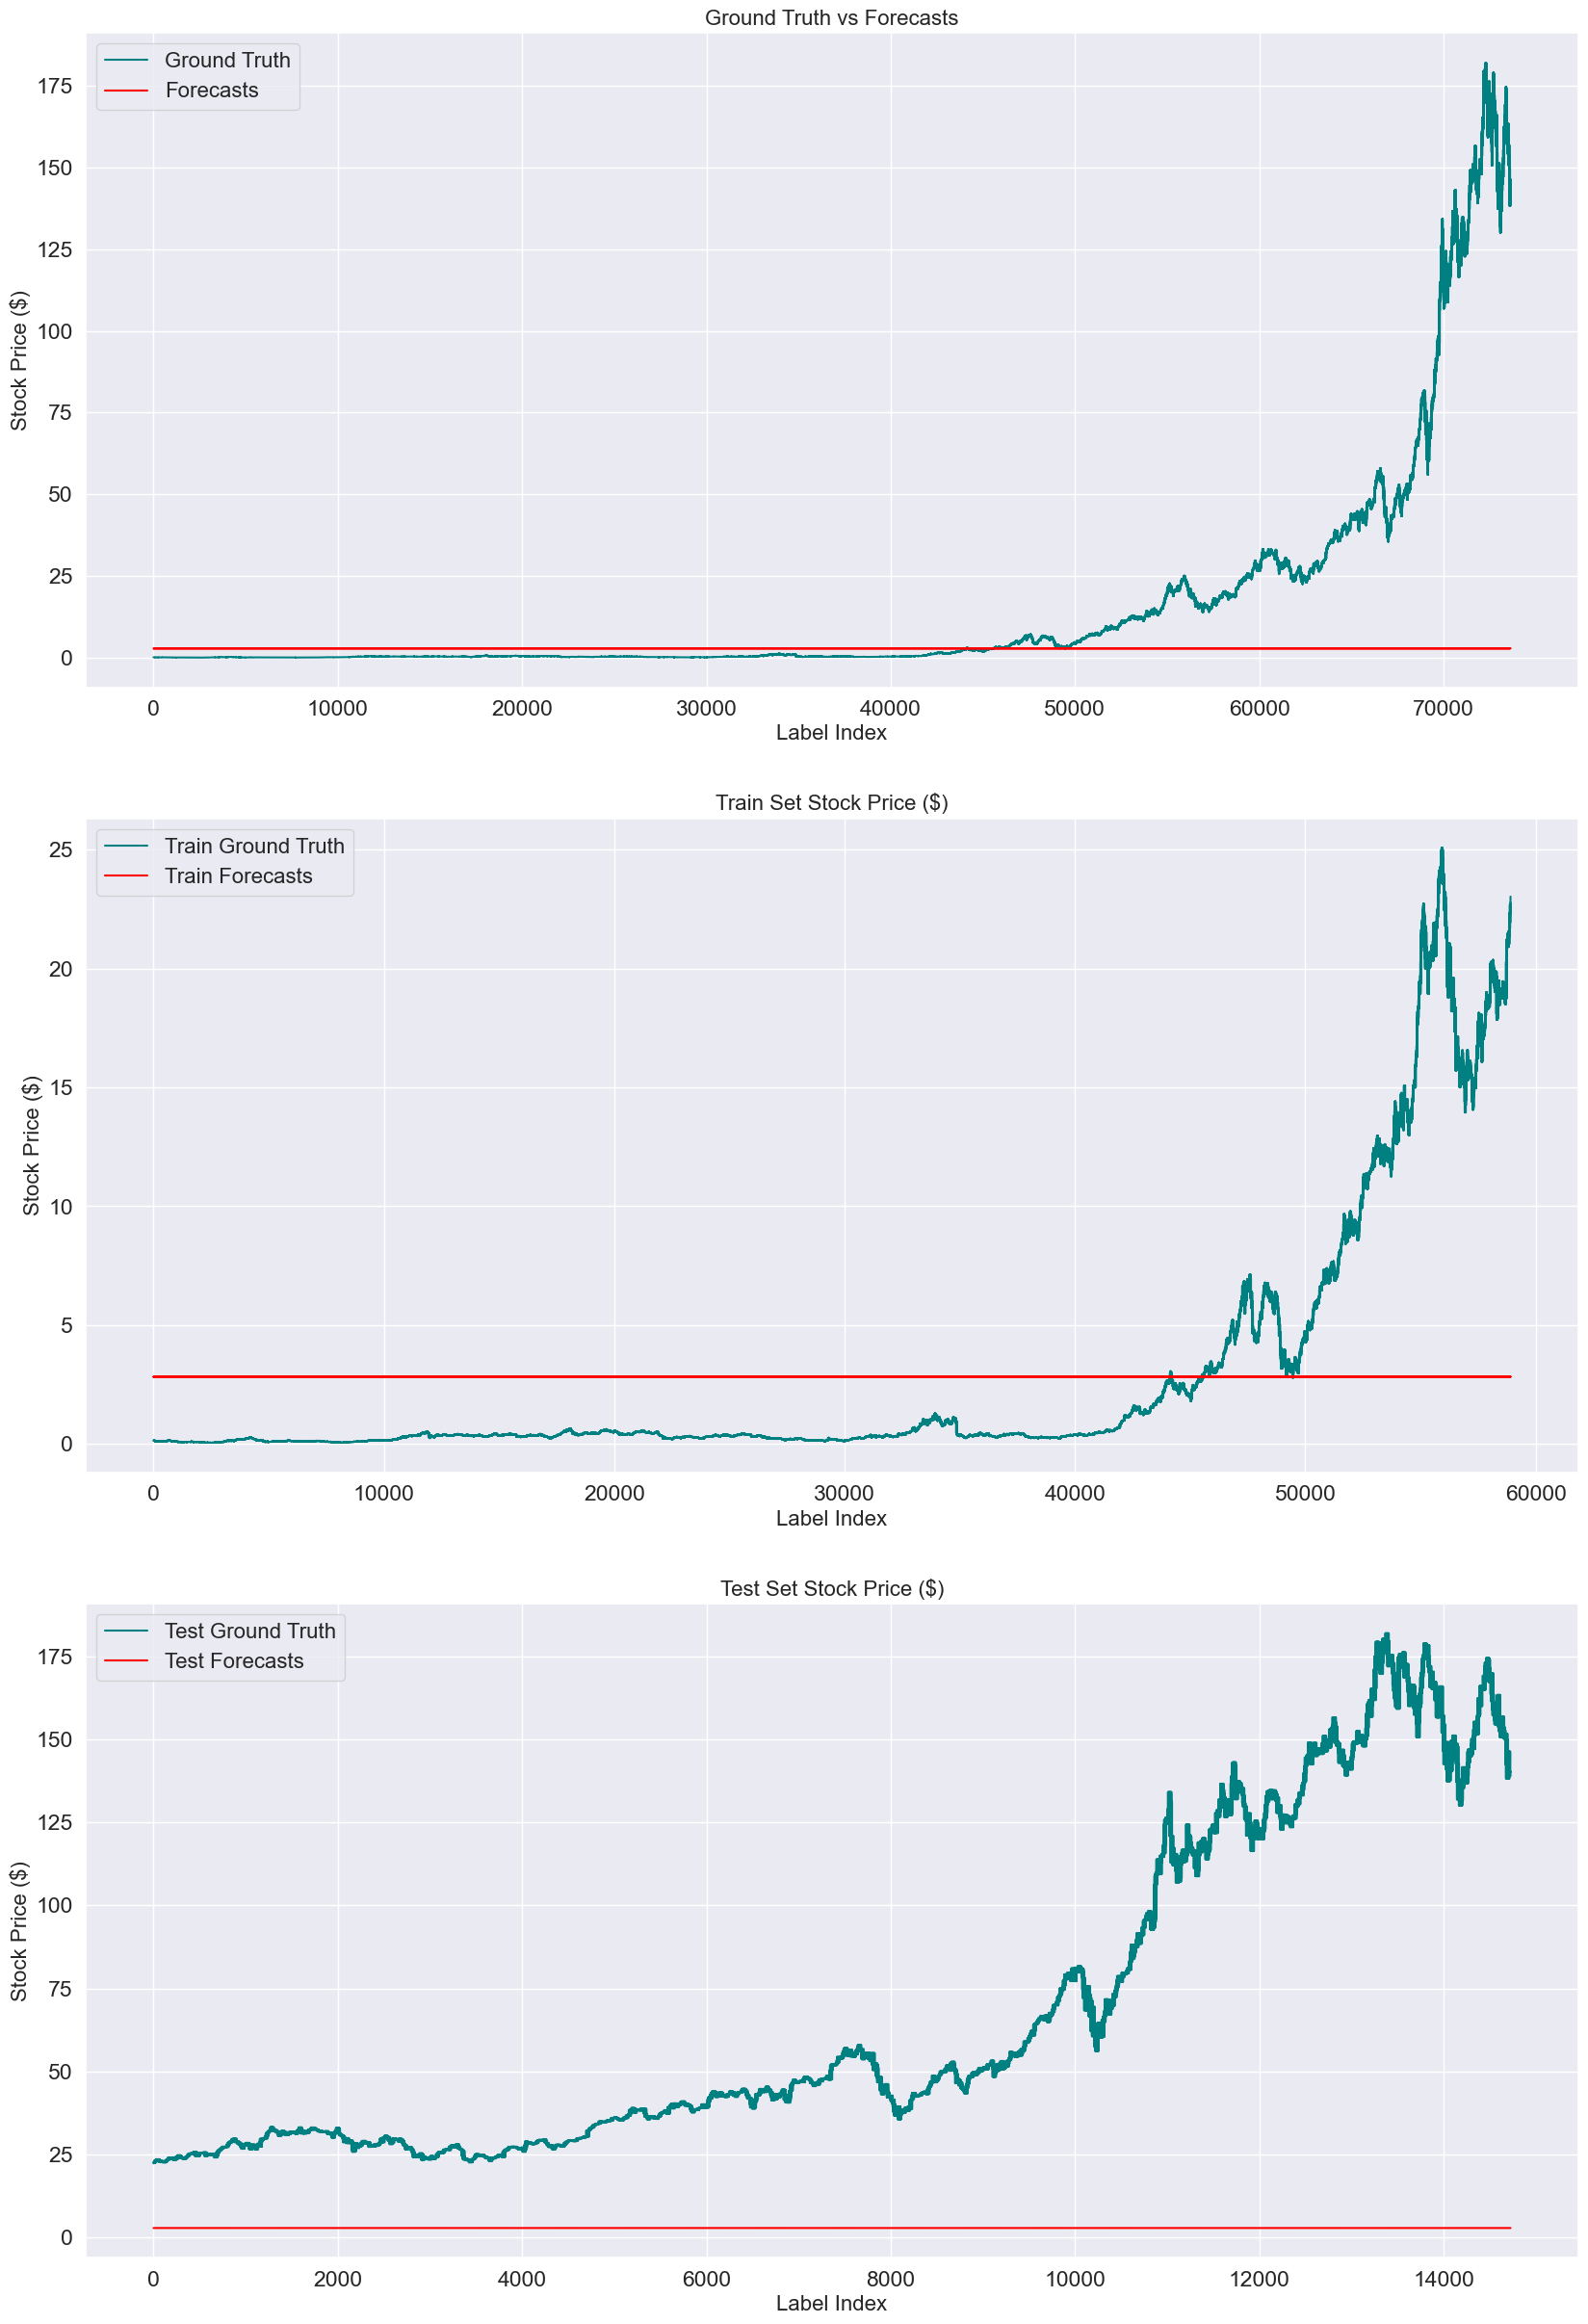

In [8]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = baseline_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

Let"s call the  function to evaluate the performance of the model.

In [9]:
# Calling the function to evaluate the performance of the model
baseline_model_summary_df = evaluate_model_performance(model = baseline_model,
                                                       train_features = X_train,
                                                       train_labels = y_train,
                                                       test_features = X_test,
                                                       test_labels = y_test,
                                                       algorithm_name = "Baseline")
# Displaying the evaluation summary
baseline_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Baseline,8.8,0.94,3.69,64.88,28.55,6498.95,5.34,80.62


***
### Linear Regression

In [10]:
# Calling the function to the build a forecasting pipeline
lr_model = build_pipeline(regressor = LinearRegression(n_jobs = -1),
                          apply_feature_scaling = True,
                          scaler_type = "robust",
                          train_features = X_train, 
                          train_labels = y_train)

# logging information to the log file
logging.info(msg = "Forecaster with Linear Regression algorithm has been built")

# Displaying the architecture of the regressor
lr_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('feature_scaler', RobustScaler()),
                ('regressor', LinearRegression(n_jobs=-1))])

Let"s call the function to visually compare forecasts to ground truths.

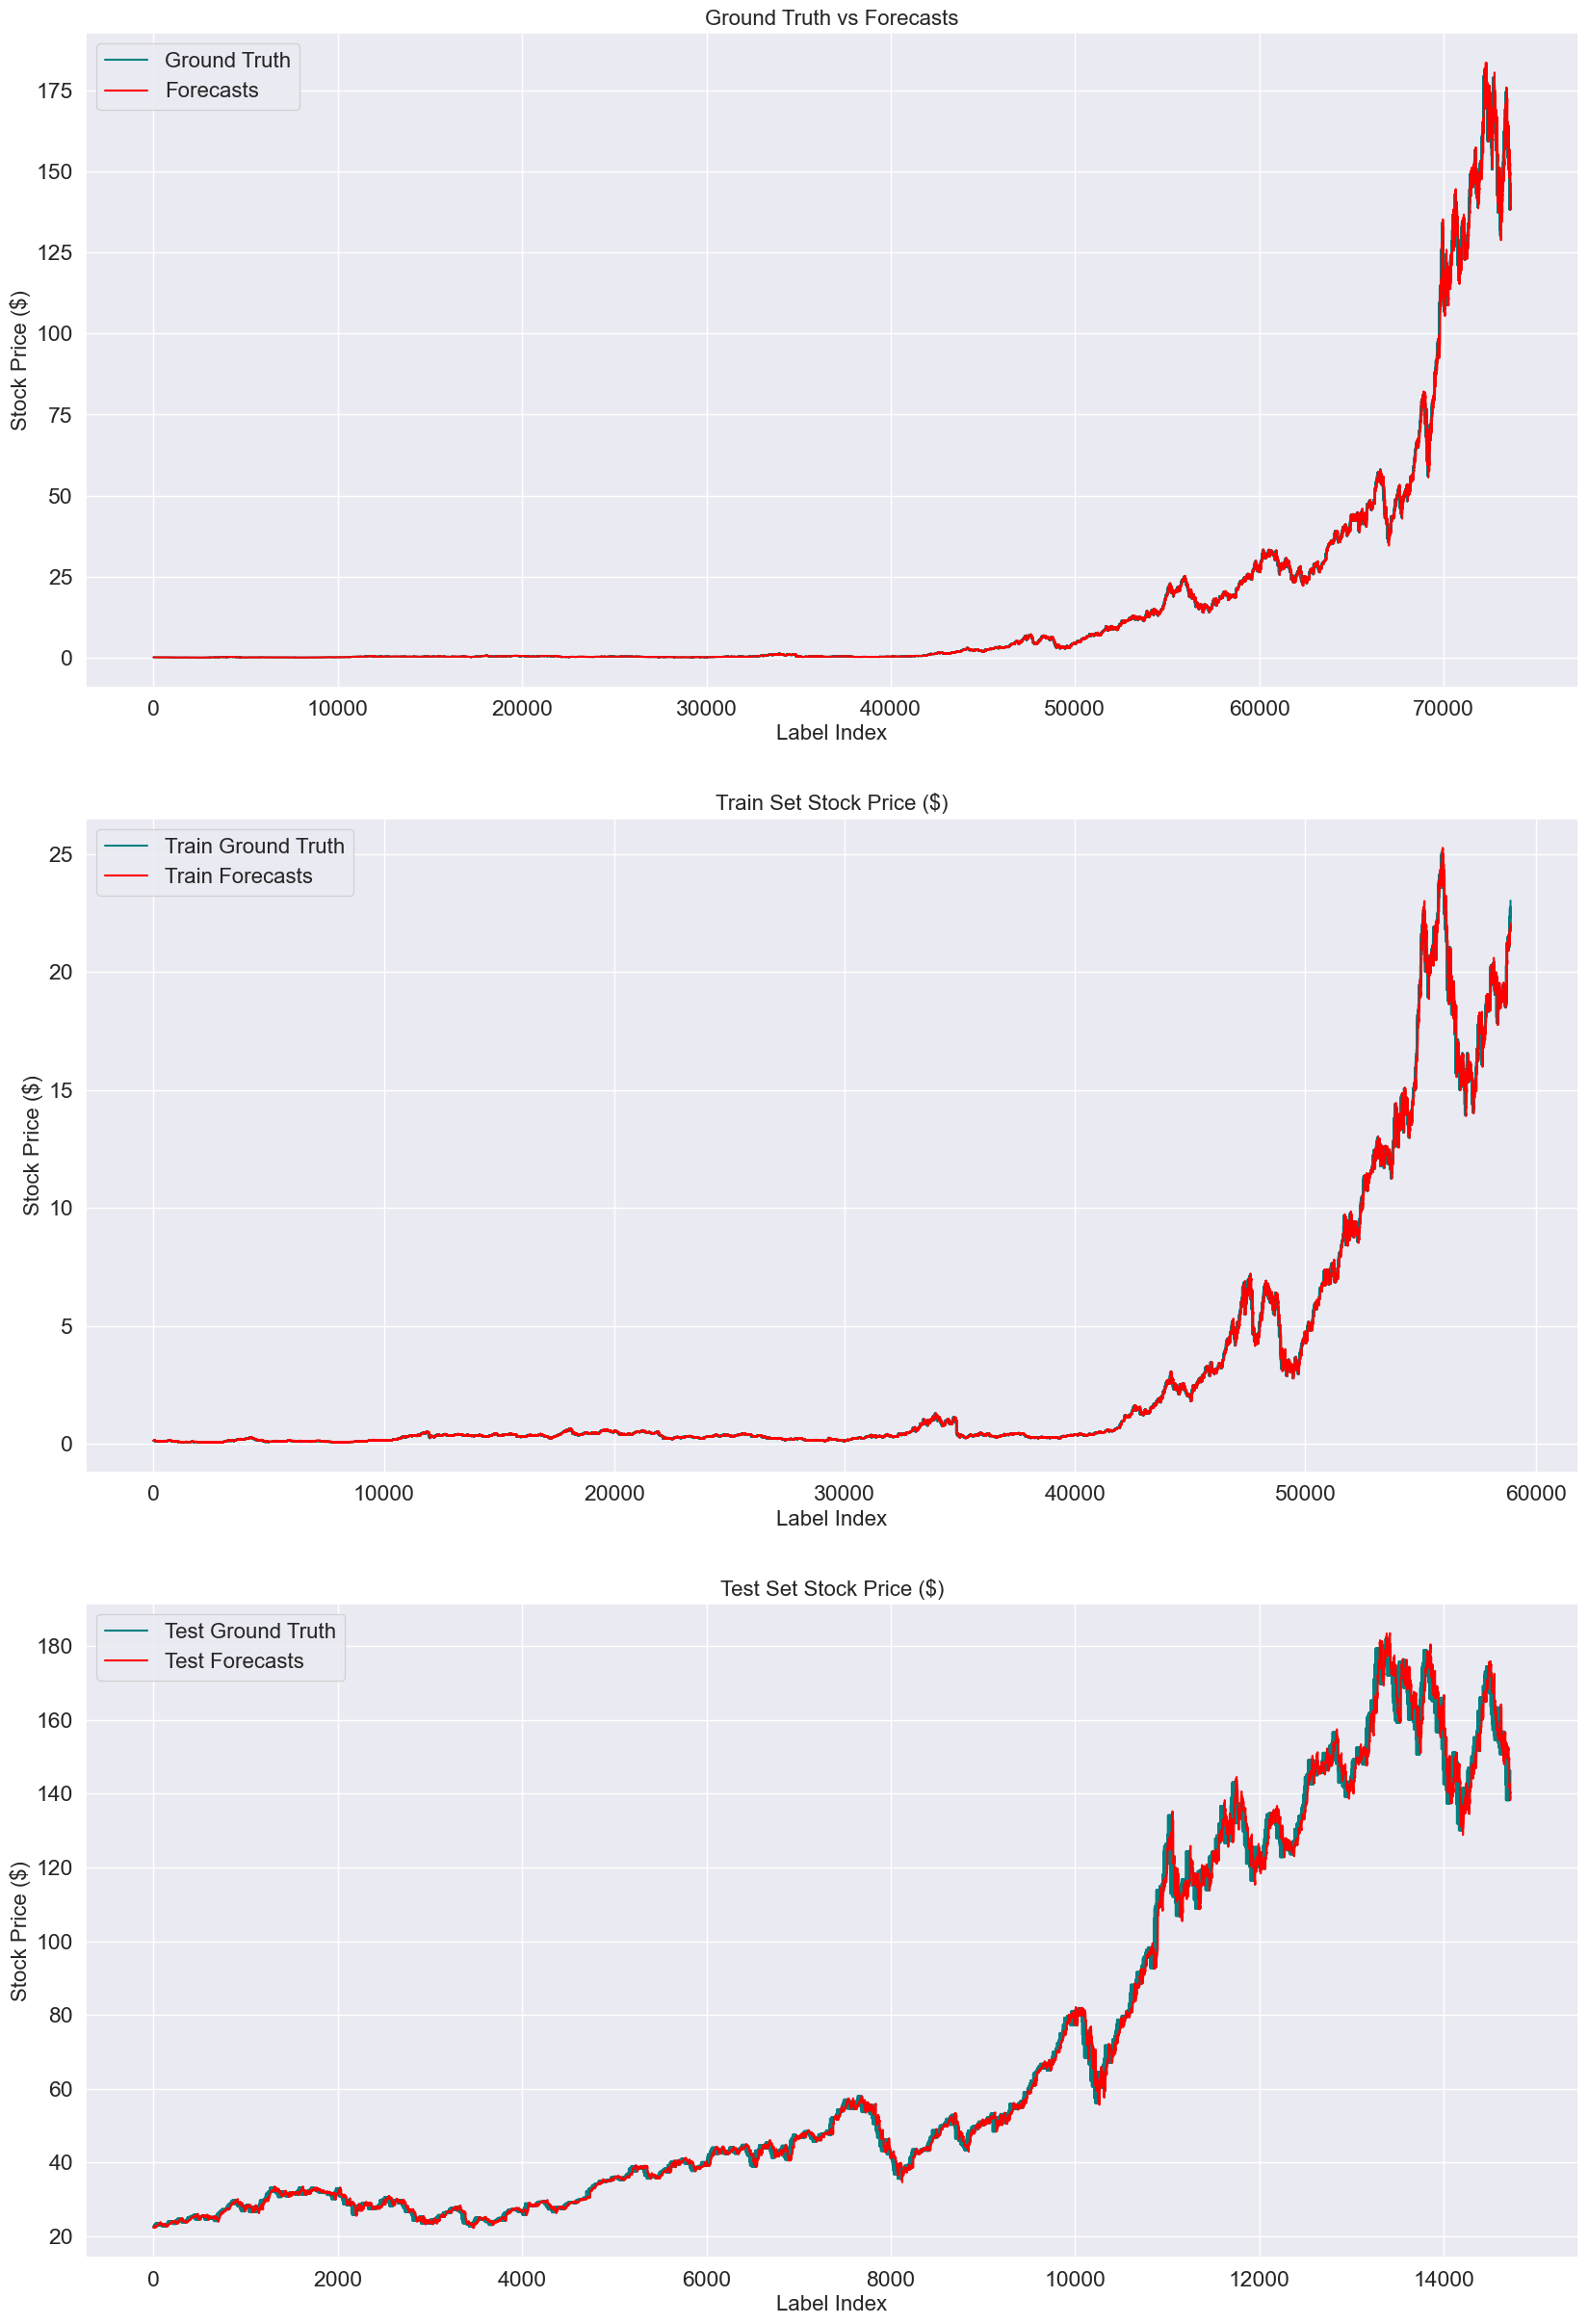

In [11]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = lr_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

Let"s call the  function to evaluate the performance of the model.

In [12]:
# Calling the function to evaluate the performance of the model
lr_model_summary_df = evaluate_model_performance(model = lr_model,
                                                 train_features = X_train,
                                                 train_labels = y_train,
                                                 test_features = X_test,
                                                 test_labels = y_test,
                                                 algorithm_name = "Linear Regression")
# Displaying the evaluation summary
lr_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Linear Regression,0.05,0.02,0.09,1.82,0.05,9.72,0.22,3.12


***
#### Support Vector Machine

In [13]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a list of feature scaler instances
scalers = [RobustScaler(), MinMaxScaler(), MaxAbsScaler(), StandardScaler(), PowerTransformer(method = "box-cox")]

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_scaler"] = skopt.space.Categorical(categories = scalers)
search_spaces["regressor__estimator__kernel"] = skopt.space.Categorical(categories = ["rbf", "linear"])
search_spaces["regressor__estimator__tol"] = skopt.space.Real(low = 1e-6, high = 1.0, prior = "log-uniform")
search_spaces["regressor__estimator__C"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")

# Calling the function to the build a forecasting pipeline
svm_model = build_pipeline(regressor = SVR(),
                           apply_feature_scaling = True,
                           scaler_type = "minmax",
                           support_multioutput = False,
                           apply_bayesian_optimization = True,
                           hyperparameters = search_spaces,
                           train_features = X_train, 
                           train_labels = y_train,
                           n_iterations = 100)

# logging information to the log file
logging.info(msg = "Forecaster with Support Vector Machine algorithm has been built")

# Displaying the architecture of the regressor
svm_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('feature_scaler', RobustScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=SVR(C=0.01490301896195763,
                                                    kernel='linear',
                                                    tol=1e-06),
                                      n_jobs=-1))])

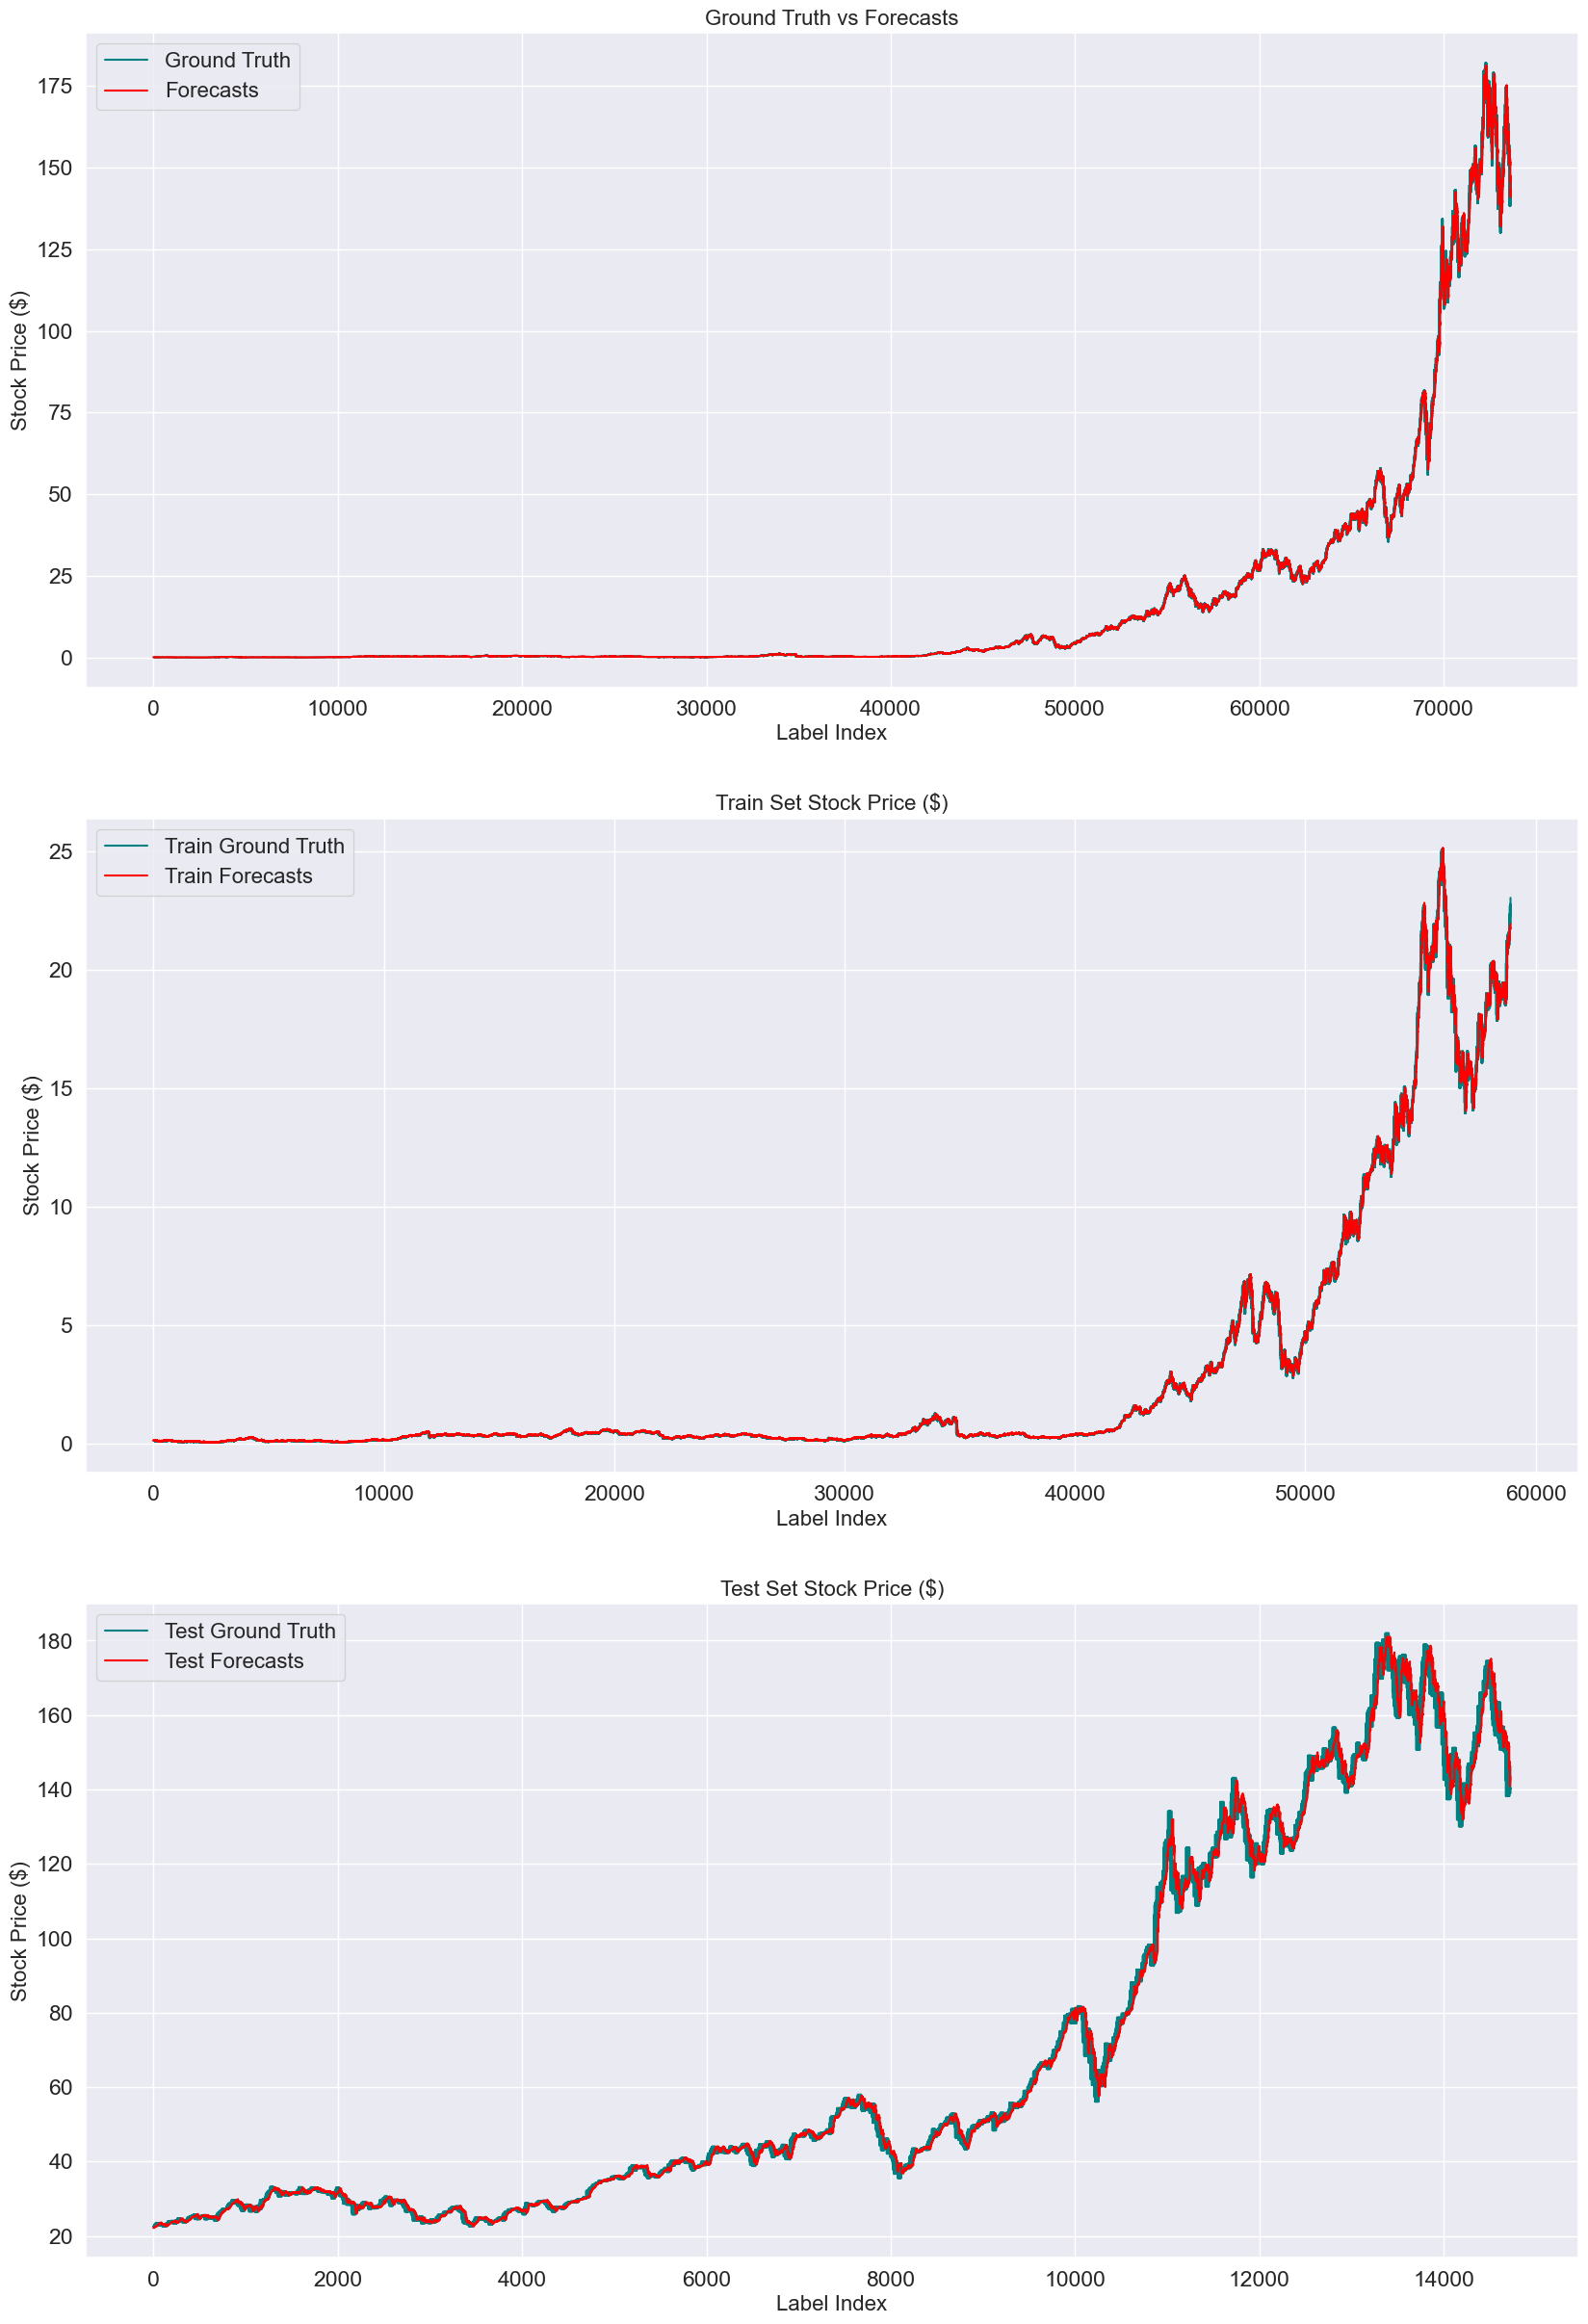

In [14]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = svm_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [15]:
# Calling the function to evaluate the performance of the model
svm_model_summary_df = evaluate_model_performance(model = svm_model,
                                                  train_features = X_train,
                                                  train_labels = y_train,
                                                  test_features = X_test,
                                                  test_labels = y_test,
                                                  algorithm_name = "Support Vector Machine")
# Displaying the evaluation summary
svm_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Support Vector Machine,0.08,0.03,0.09,1.88,0.05,10.12,0.22,3.18


***
#### Bayesian Ridge

In [16]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_scaler"] = skopt.space.Categorical(categories = scalers)
search_spaces["regressor__estimator__alpha_1"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__estimator__alpha_2"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__estimator__lambda_1"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__estimator__lambda_2"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")

# Calling the function to the build a forecasting pipeline
br_model = build_pipeline(regressor = BayesianRidge(),
                          apply_feature_scaling = True,
                          scaler_type = "standard",
                          support_multioutput = False,
                          apply_bayesian_optimization = True,
                          hyperparameters = search_spaces,
                          train_features = X_train, 
                          train_labels = y_train,
                          n_iterations = 100)

# logging information to the log file
logging.info(msg = "Forecaster with Bayesian Ridge algorithm has been built")

# Displaying the architecture of the regressor
br_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('feature_scaler', StandardScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=BayesianRidge(alpha_1=0.1,
                                                              alpha_2=0.1,
                                                              lambda_1=0.1,
                                                              lambda_2=0.1),
                                      n_jobs=-1))])

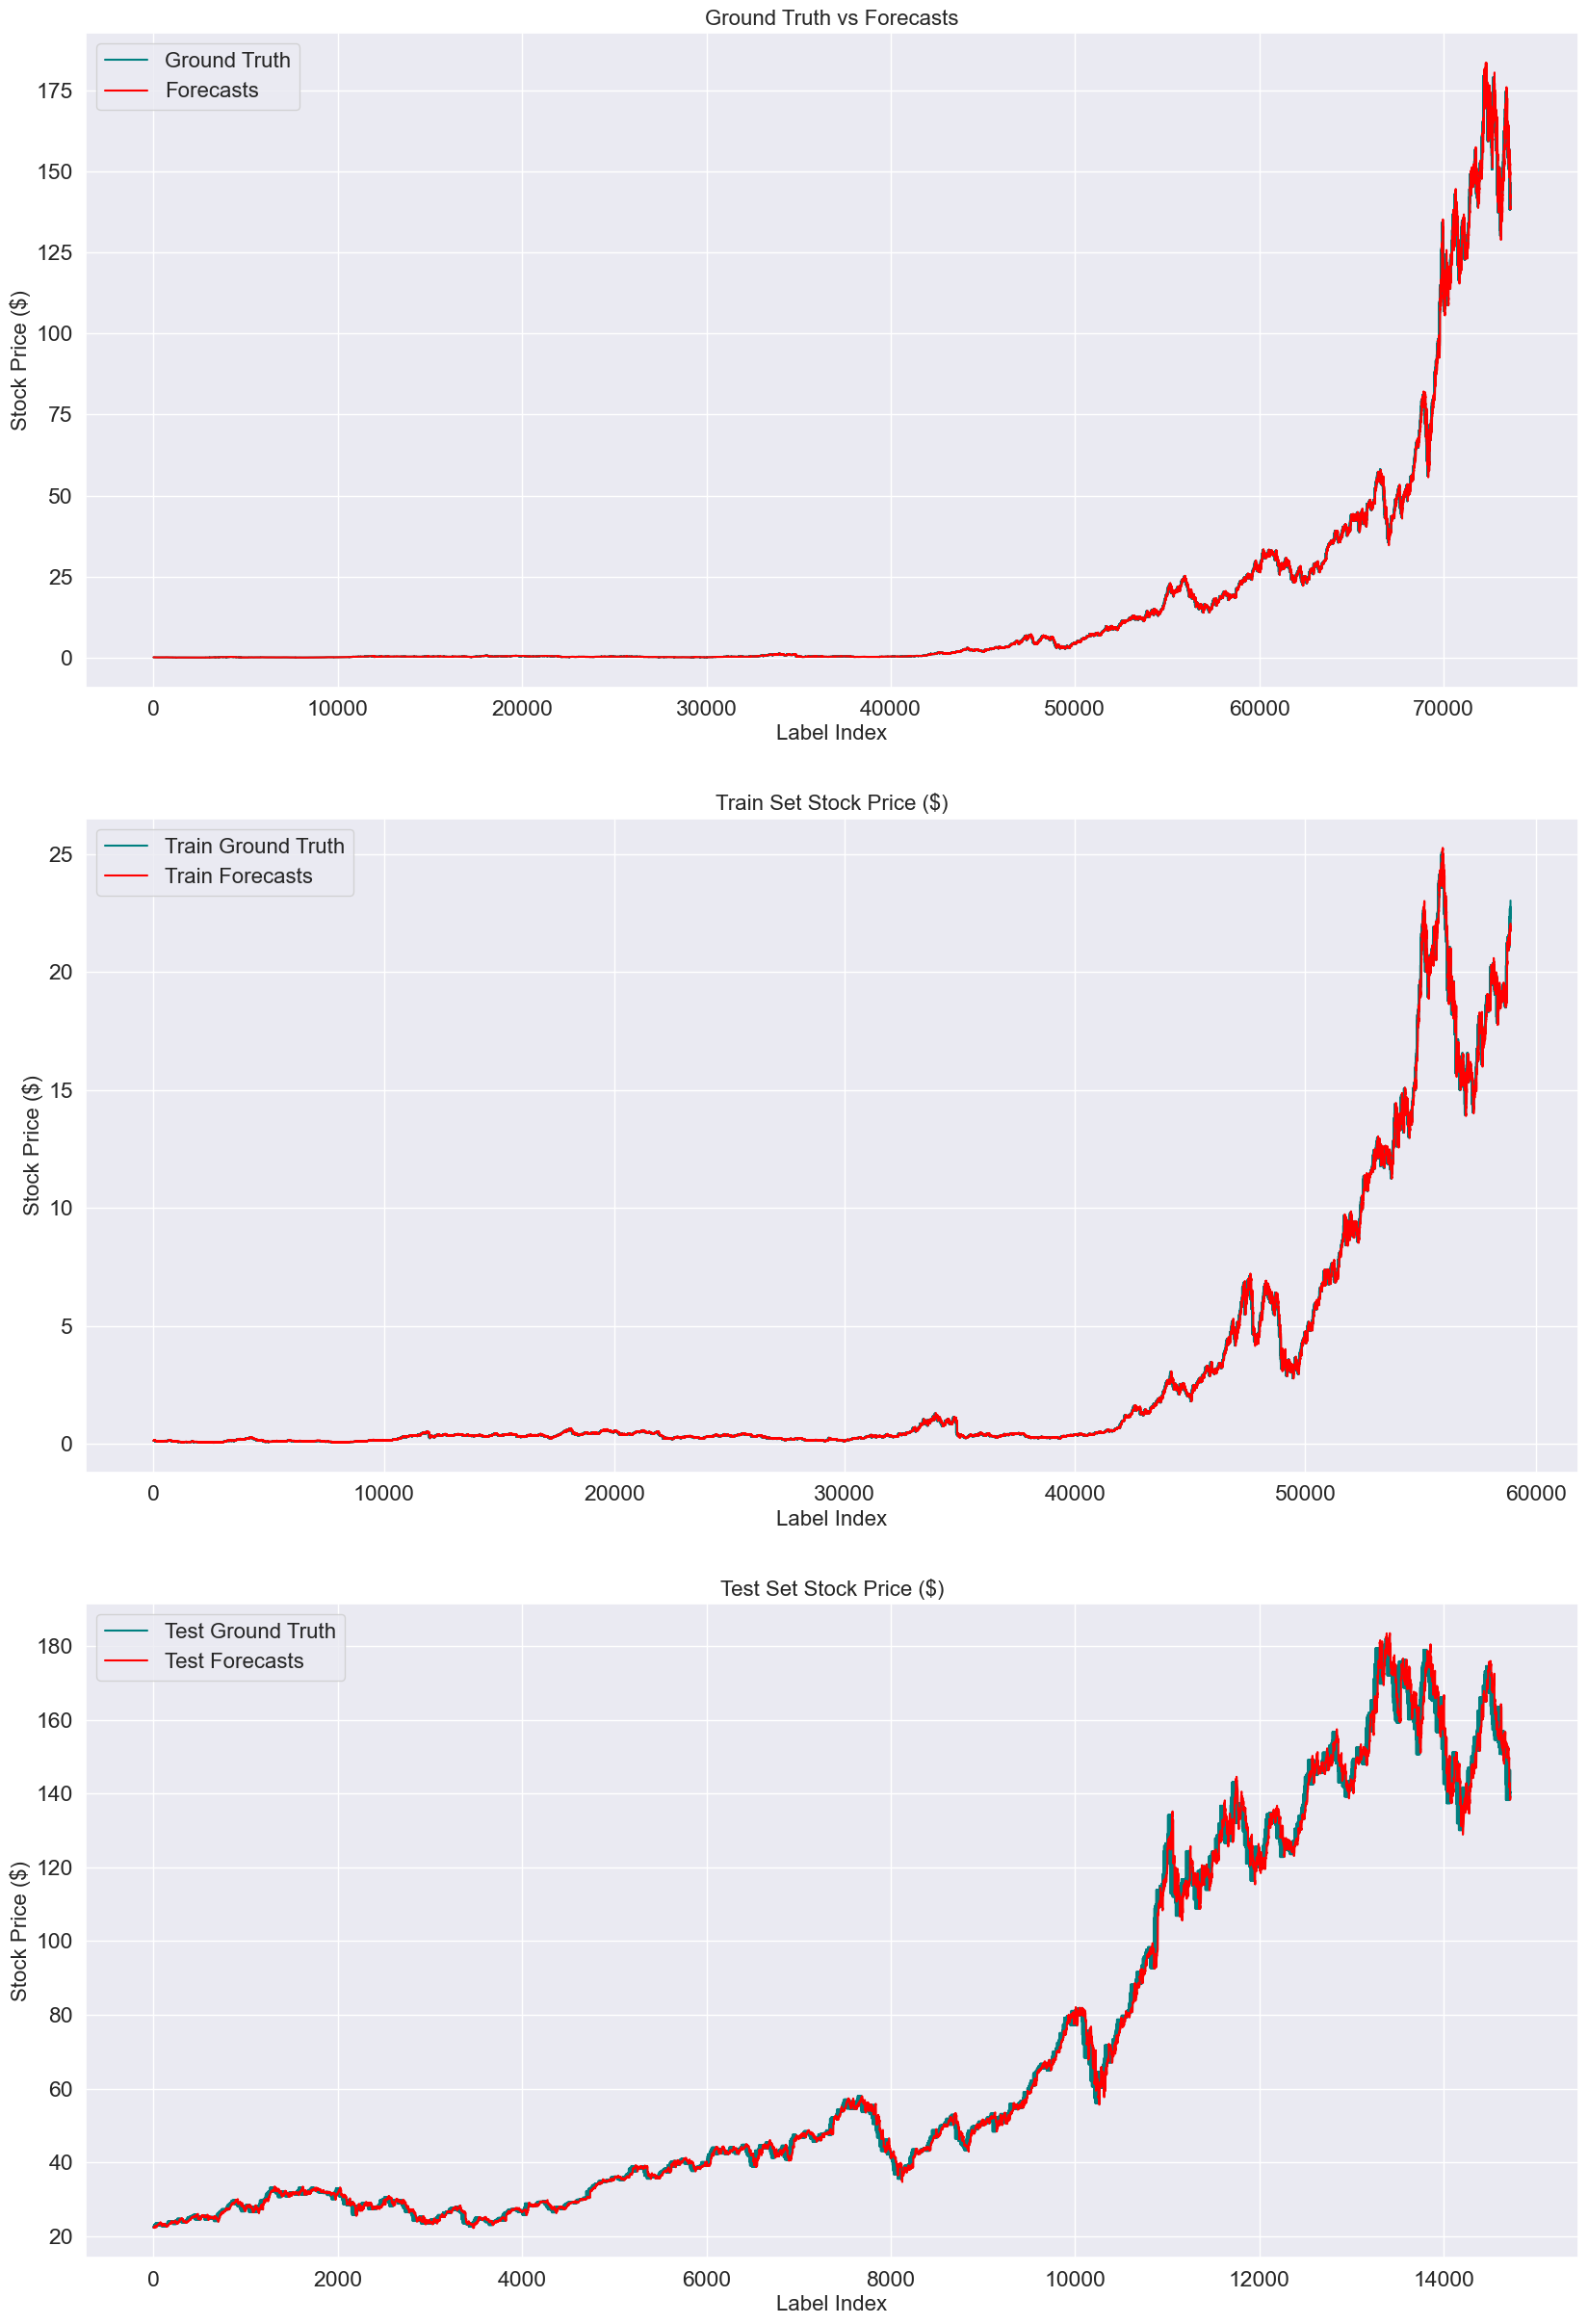

In [17]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = br_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [18]:
# Calling the function to evaluate the performance of the model
br_model_summary_df = evaluate_model_performance(model = br_model,
                                                 train_features = X_train,
                                                 train_labels = y_train,
                                                 test_features = X_test,
                                                 test_labels = y_test,
                                                 algorithm_name = "Bayesian Ridge")
# Displaying the evaluation summary
br_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Bayesian Ridge,0.05,0.02,0.09,1.82,0.05,9.71,0.22,3.12


***
#### K Nearest Neighbors

In [19]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_scaler"] = skopt.space.Categorical(categories = scalers)
search_spaces["regressor__n_neighbors"] = skopt.space.Integer(low = 2, high = 10)
search_spaces["regressor__weights"] = skopt.space.Categorical(categories = ["uniform", "distance"])

# Calling the function to the build a forecasting pipeline
knn_model = build_pipeline(regressor = KNeighborsRegressor(n_jobs = -1),
                           apply_feature_scaling = True,
                           scaler_type = "maxabs",
                           apply_bayesian_optimization = True,
                           hyperparameters = search_spaces,
                           train_features = X_train, 
                           train_labels = y_train,
                           n_iterations = 100)

# logging information to the log file
logging.info(msg = "Forecaster with K Nearest Neighbors algorithm has been built")

# Displaying the architecture of the regressor
knn_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('feature_scaler', PowerTransformer(method='box-cox')),
                ('regressor', KNeighborsRegressor(n_jobs=-1, n_neighbors=9))])

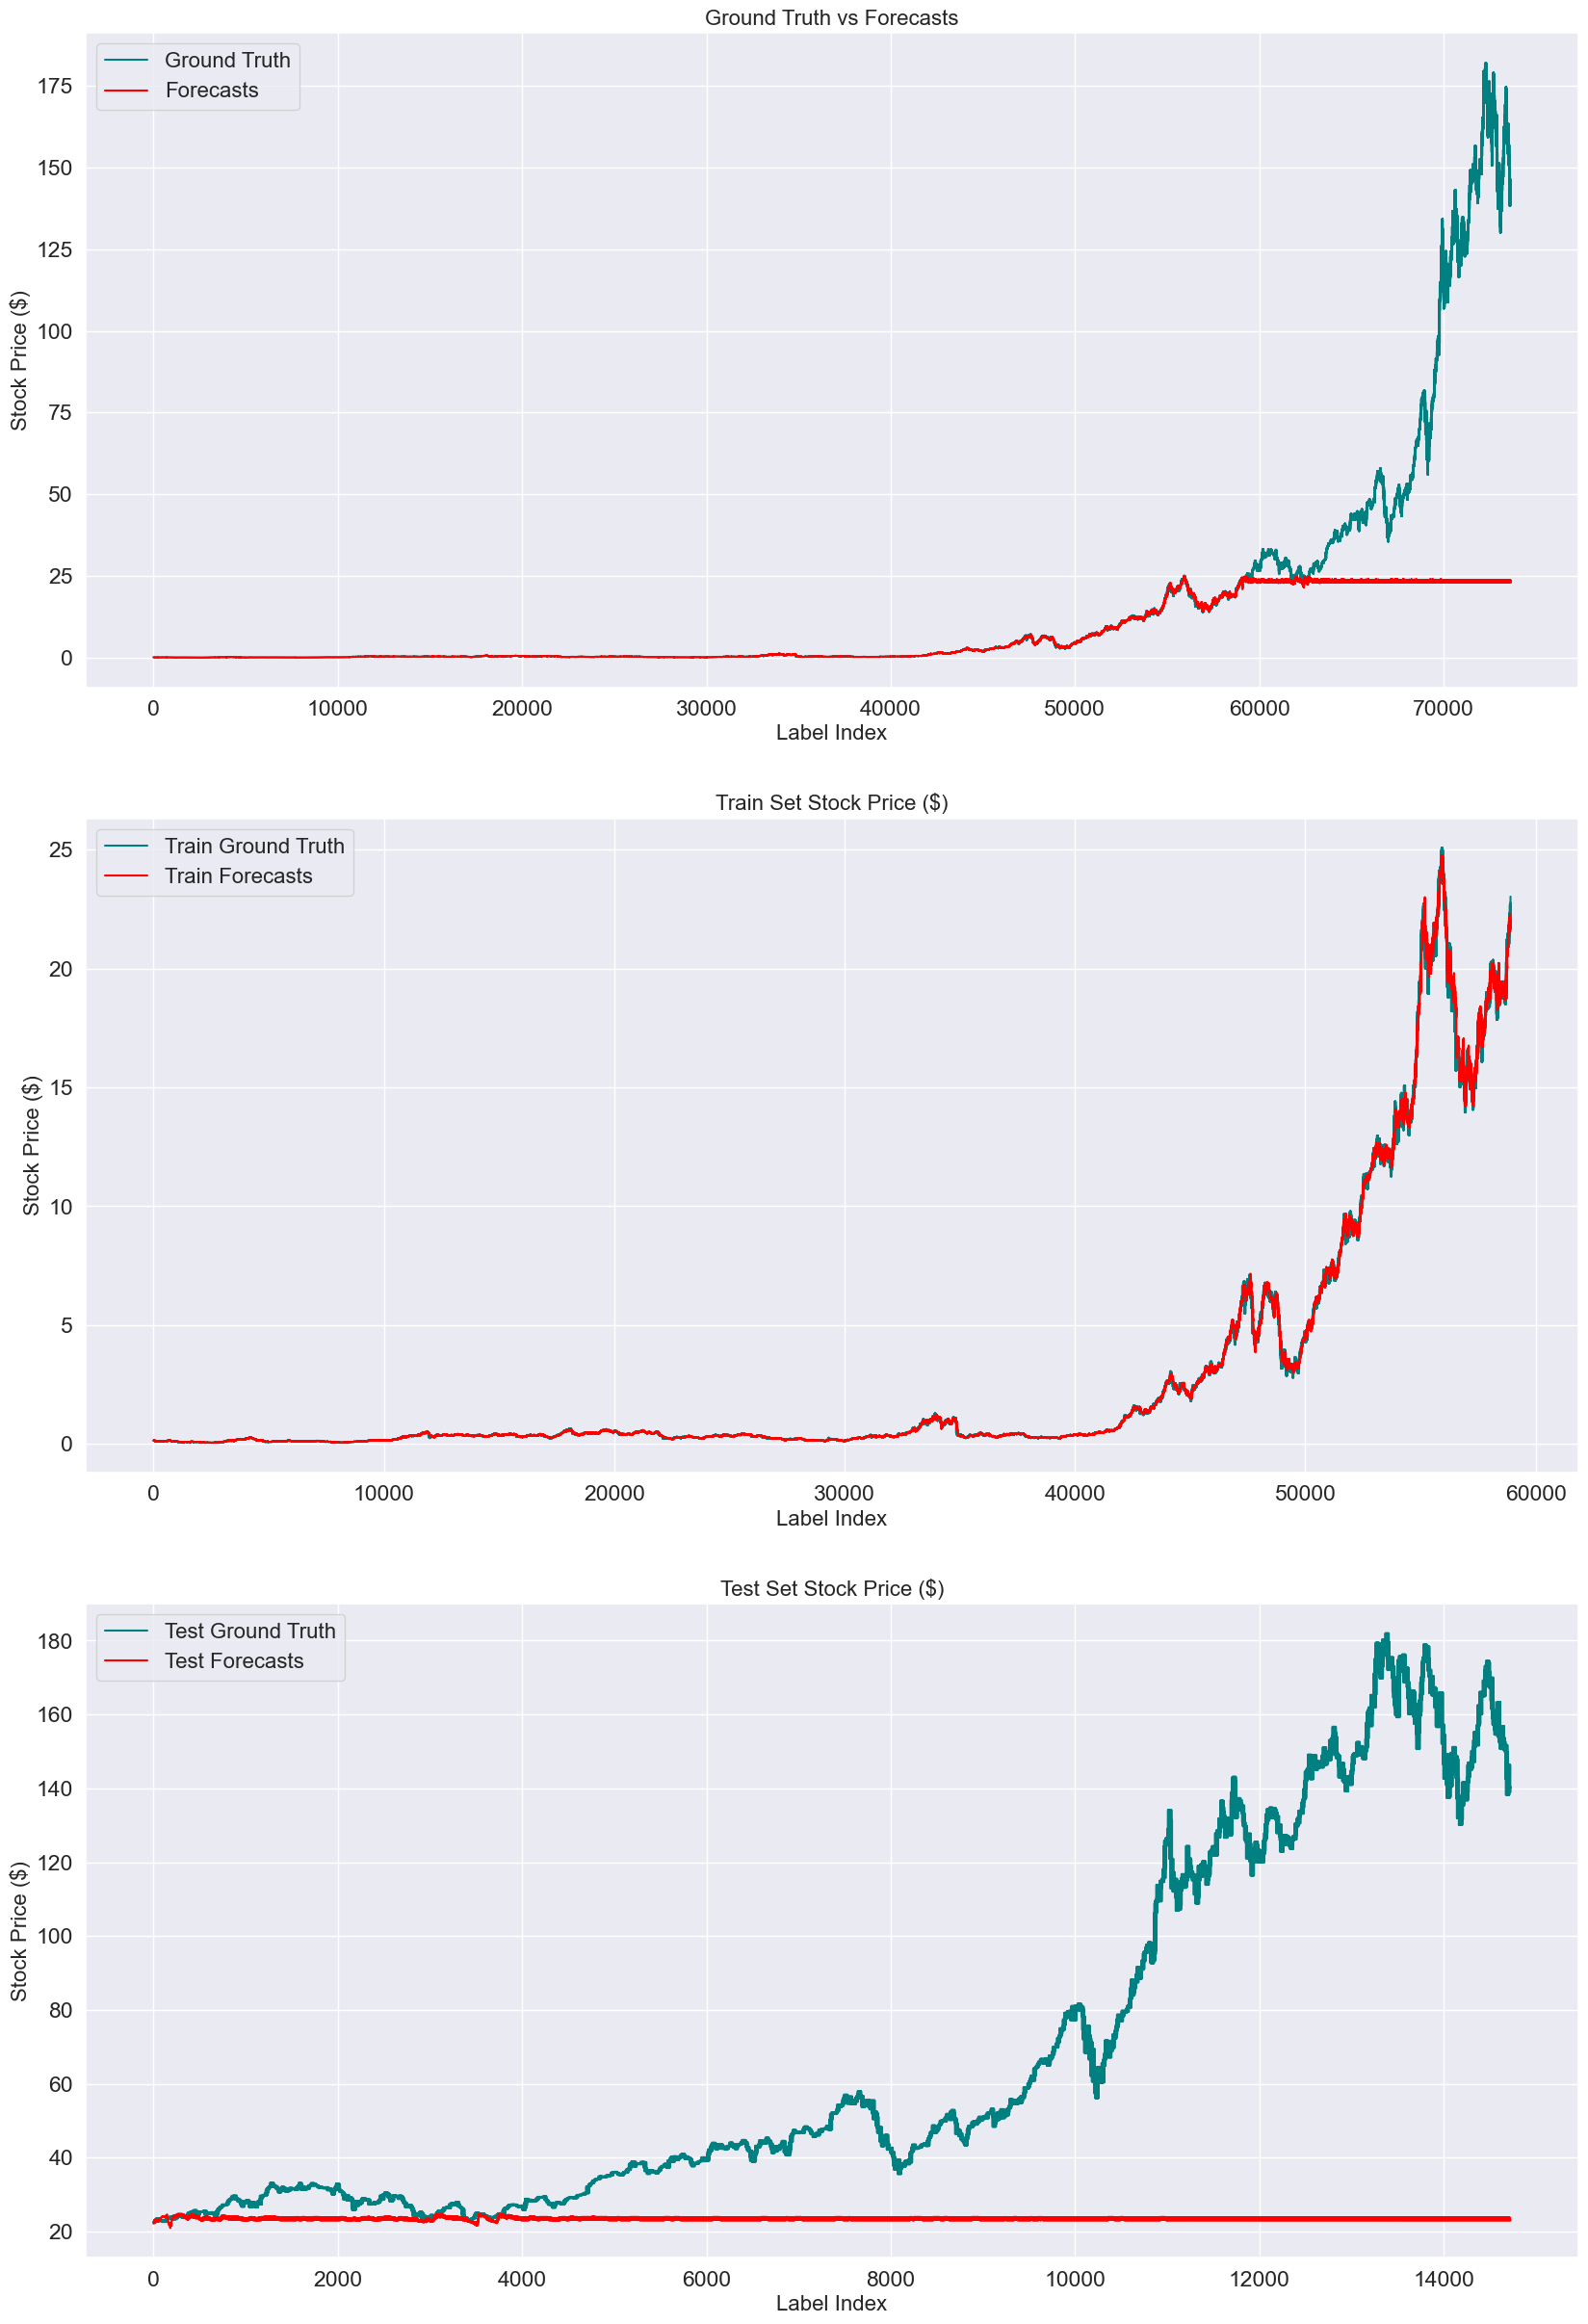

In [20]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = knn_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [21]:
# Calling the function to evaluate the performance of the model
knn_model_summary_df = evaluate_model_performance(model = knn_model,
                                                  train_features = X_train,
                                                  train_labels = y_train,
                                                  test_features = X_test,
                                                  test_labels = y_test,
                                                  algorithm_name = "K Nearest Neighbors")
# Displaying the evaluation summary
knn_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
K Nearest Neighbors,0.04,0.48,0.07,44.29,0.03,4252.42,0.17,65.21


***
#### Decision Tree

In [22]:
# Calling the function to the build a forecasting pipeline
dt_model = build_pipeline(regressor = DecisionTreeRegressor(random_state = 42),
                          train_features = X_train, 
                          train_labels = y_train)

# logging information to the log file
logging.info(msg = "Forecaster with Decision Tree algorithm has been built")

# Displaying the architecture of the regressor
dt_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor', DecisionTreeRegressor(random_state=42))])

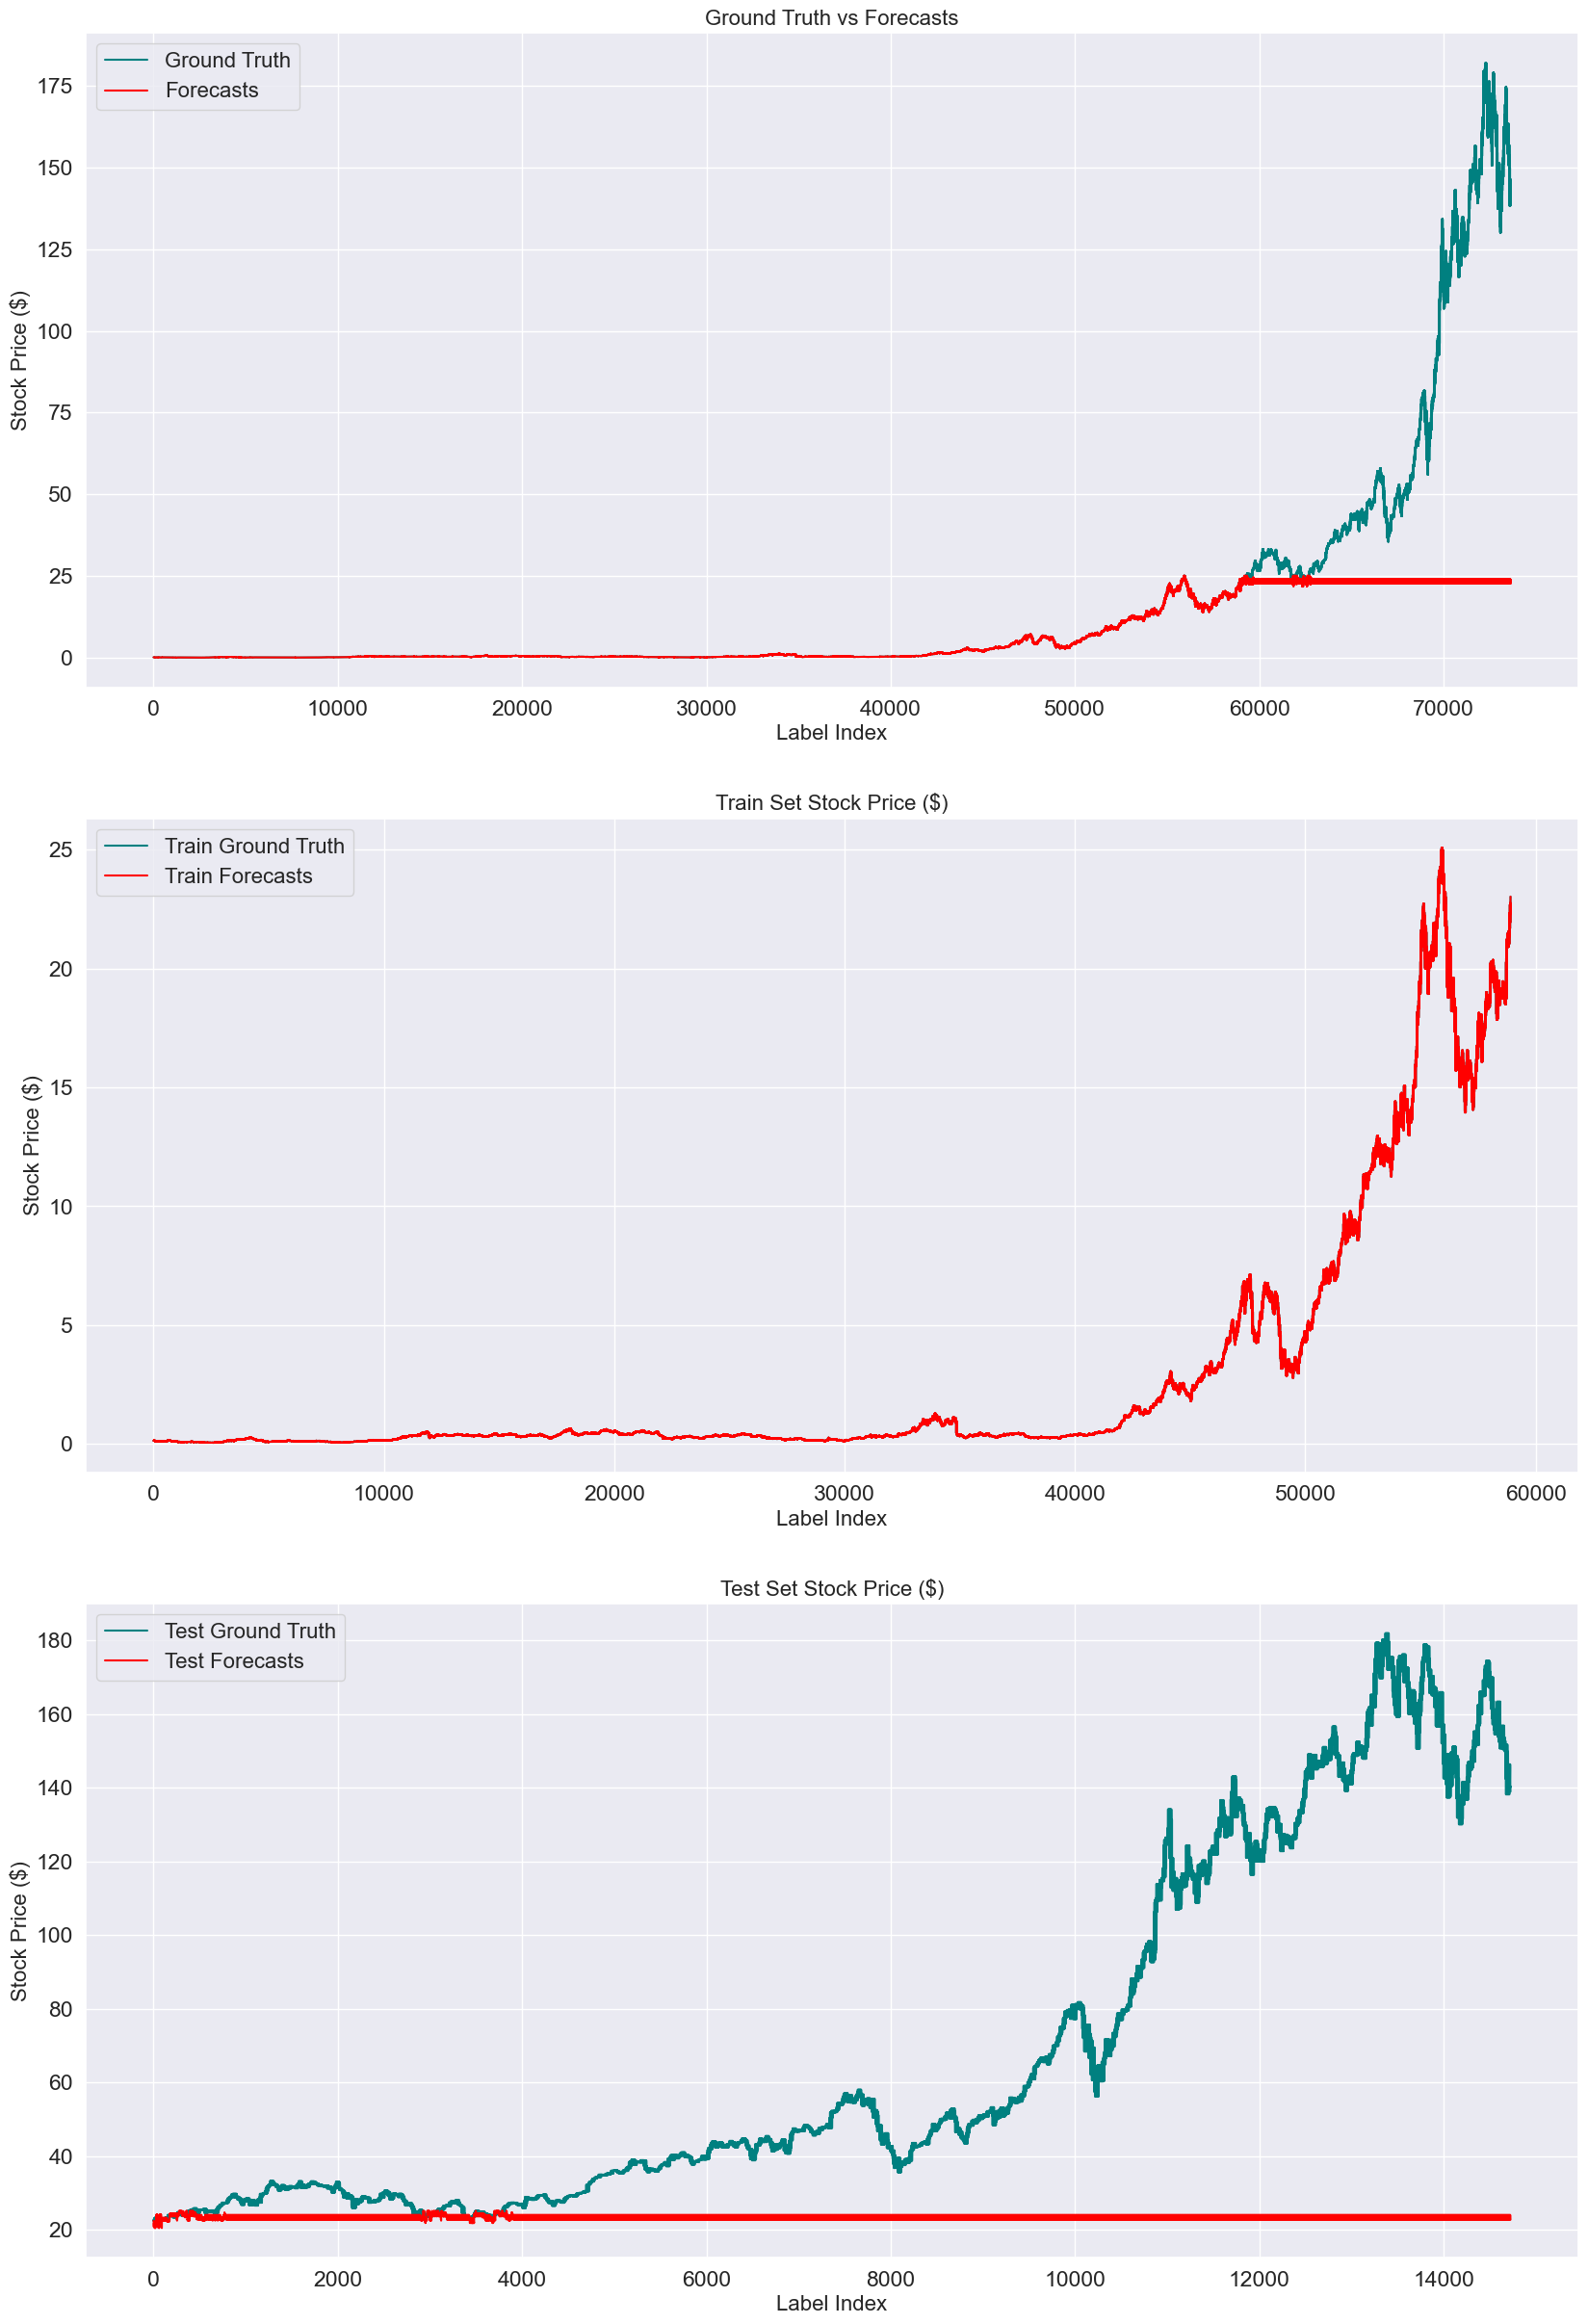

In [23]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = dt_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [24]:
# Calling the function to evaluate the performance of the model
dt_model_summary_df = evaluate_model_performance(model = dt_model,
                                                 train_features = X_train,
                                                 train_labels = y_train,
                                                 test_features = X_test,
                                                 test_labels = y_test,
                                                 algorithm_name = "Decision Tree")
# Displaying the evaluation summary
dt_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Decision Tree,0.0,0.48,0.0,44.33,0.0,4253.28,0.0,65.22


***
#### Random Forest

In [25]:
# Calling the function to the build a forecasting pipeline
rf_model = build_pipeline(regressor = RandomForestRegressor(n_jobs = -1, random_state = 42),
                          train_features = X_train, 
                          train_labels = y_train,
                          n_iterations = 100)

# logging information to the log file
logging.info(msg = "Forecaster with Random Forest algorithm has been built")

# Displaying the architecture of the regressor
rf_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

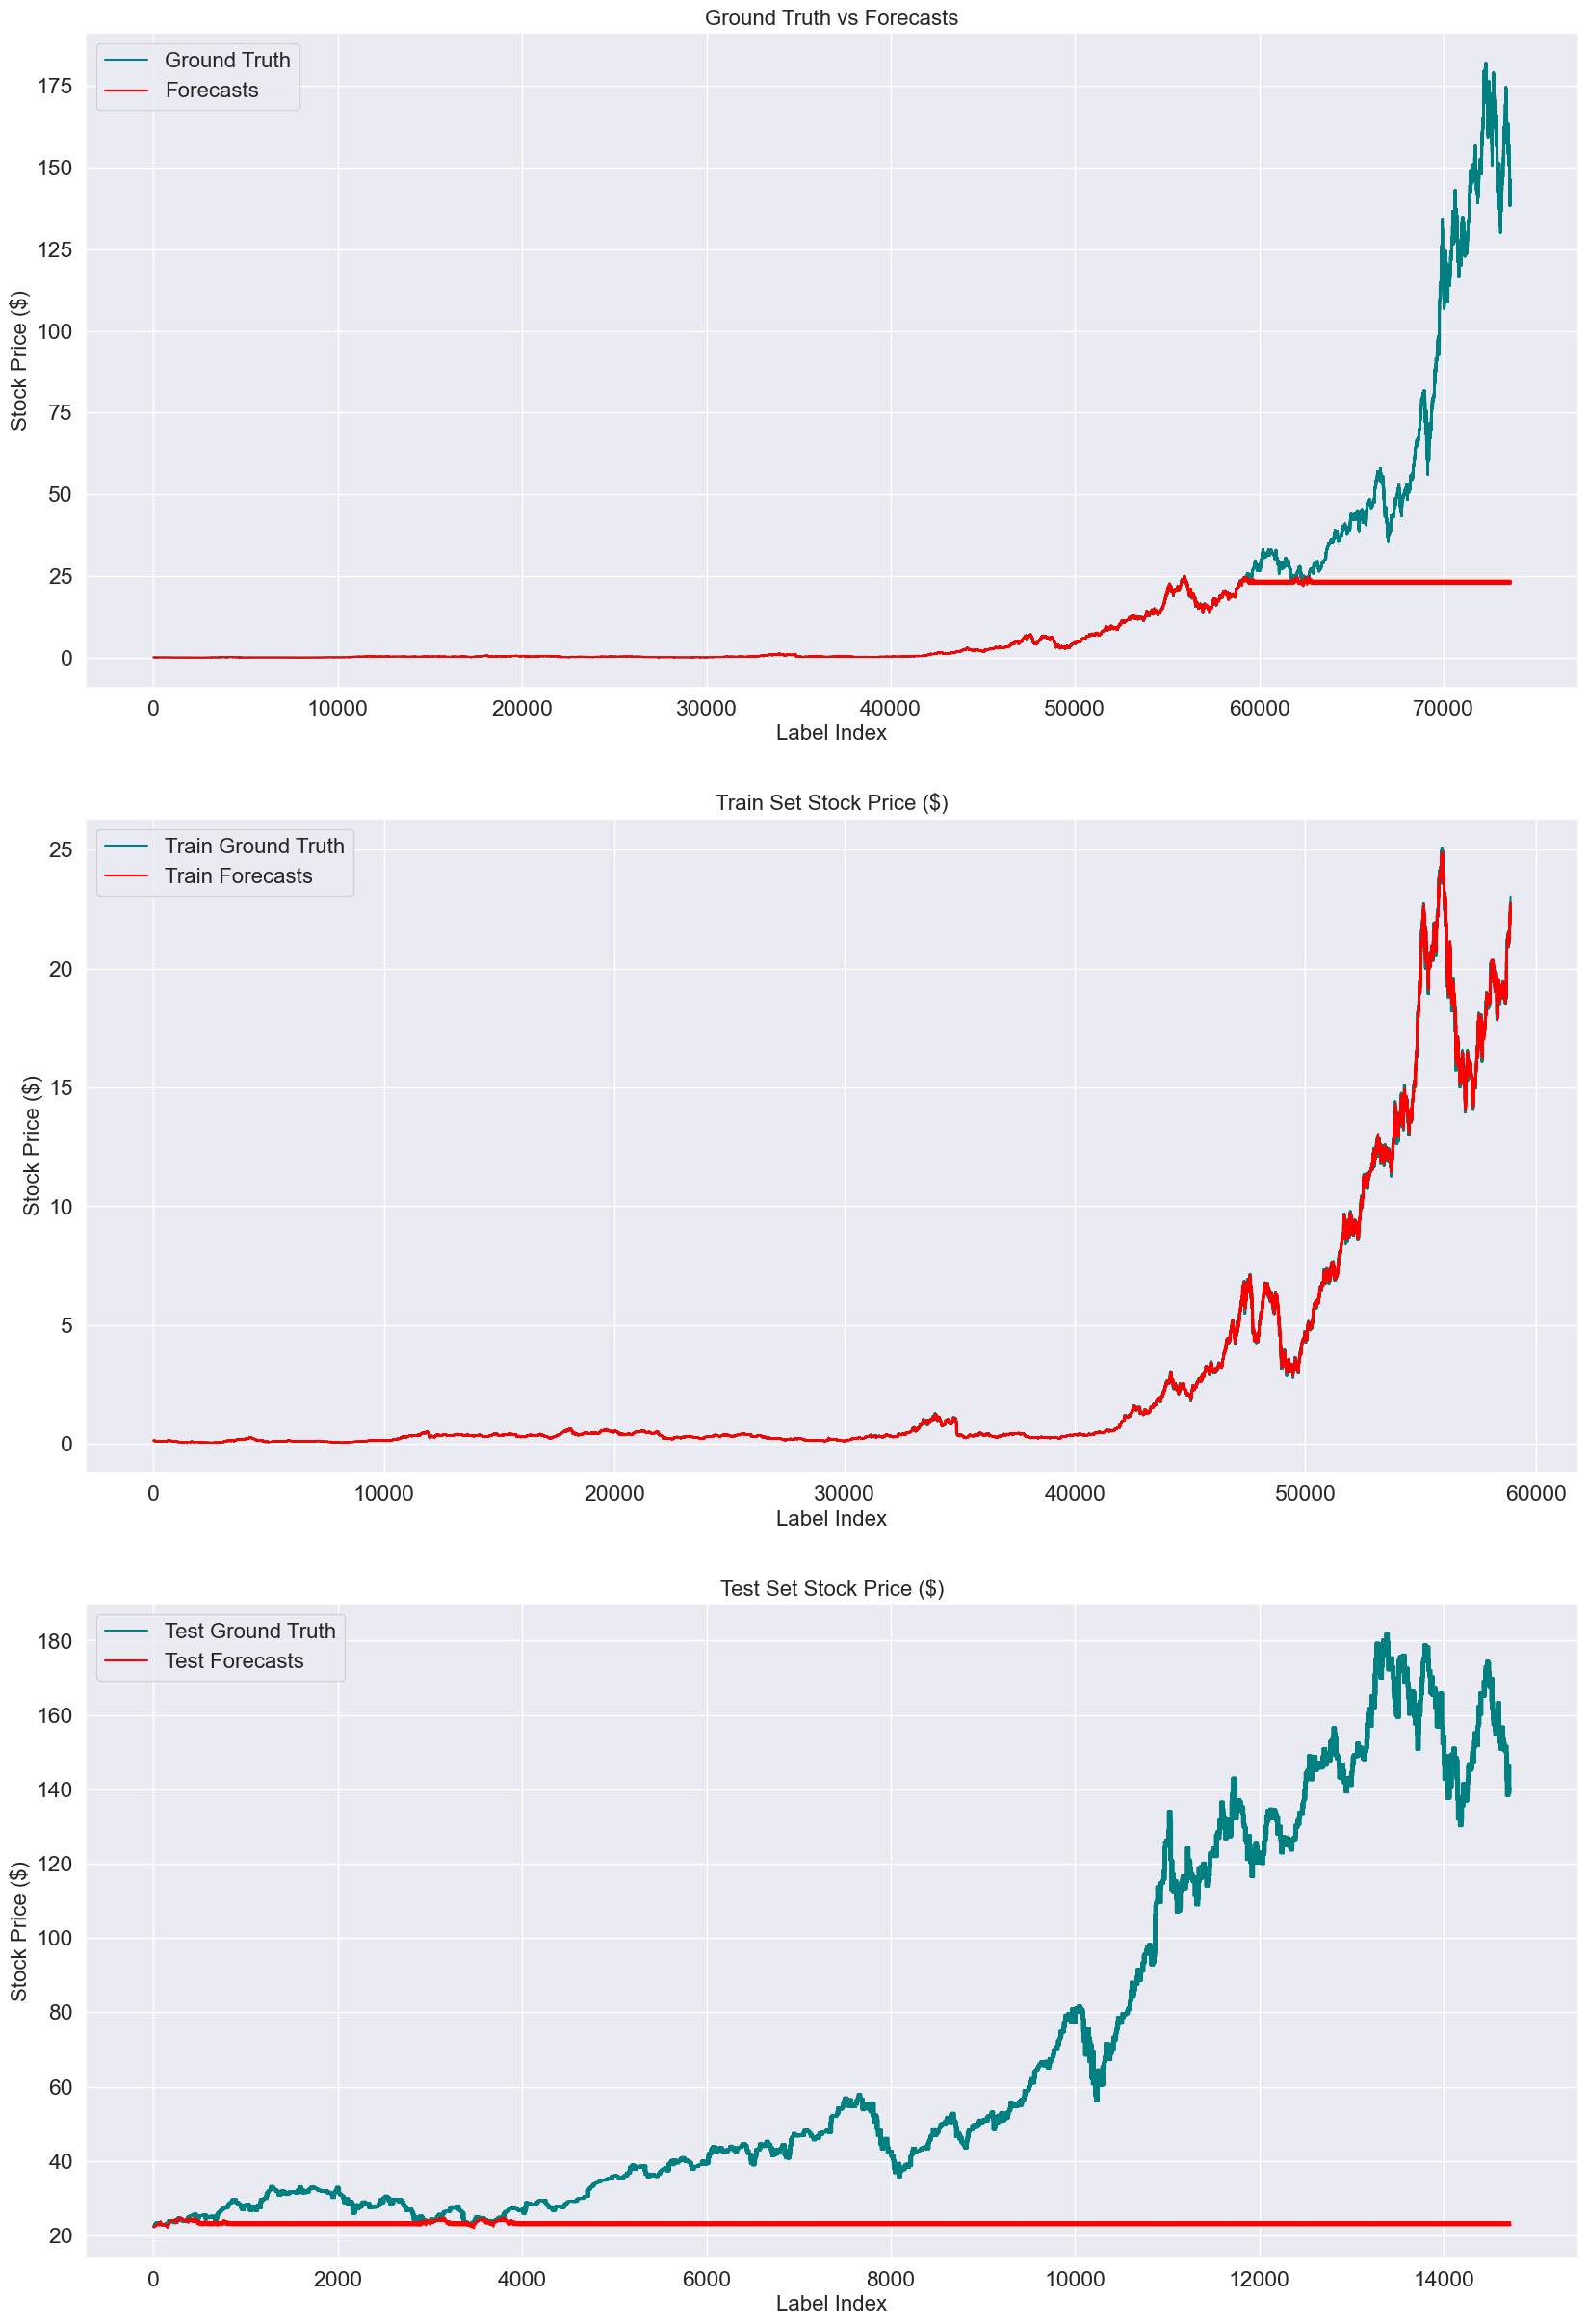

In [26]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = rf_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [27]:
# Calling the function to evaluate the performance of the model
rf_model_summary_df = evaluate_model_performance(model = rf_model,
                                                 train_features = X_train,
                                                 train_labels = y_train,
                                                 test_features = X_test,
                                                 test_labels = y_test,
                                                 algorithm_name = "Random Forest")
# Displaying the evaluation summary
rf_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Random Forest,0.01,0.48,0.03,44.55,0.0,4277.37,0.0,65.4


***
#### Gradient Boosting Machine (GBM)

In [28]:
# Calling the function to the build a forecasting pipeline
gbm_model = build_pipeline(regressor = GradientBoostingRegressor(random_state = 42),
                           support_multioutput = False,
                           train_features = X_train, 
                           train_labels = y_train,
                           n_iterations = 100)

# logging information to the log file
logging.info(msg = "Forecaster with Gradient Boosting Machine algorithm has been built")

# Displaying the architecture of the regressor
gbm_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42),
                                      n_jobs=-1))])

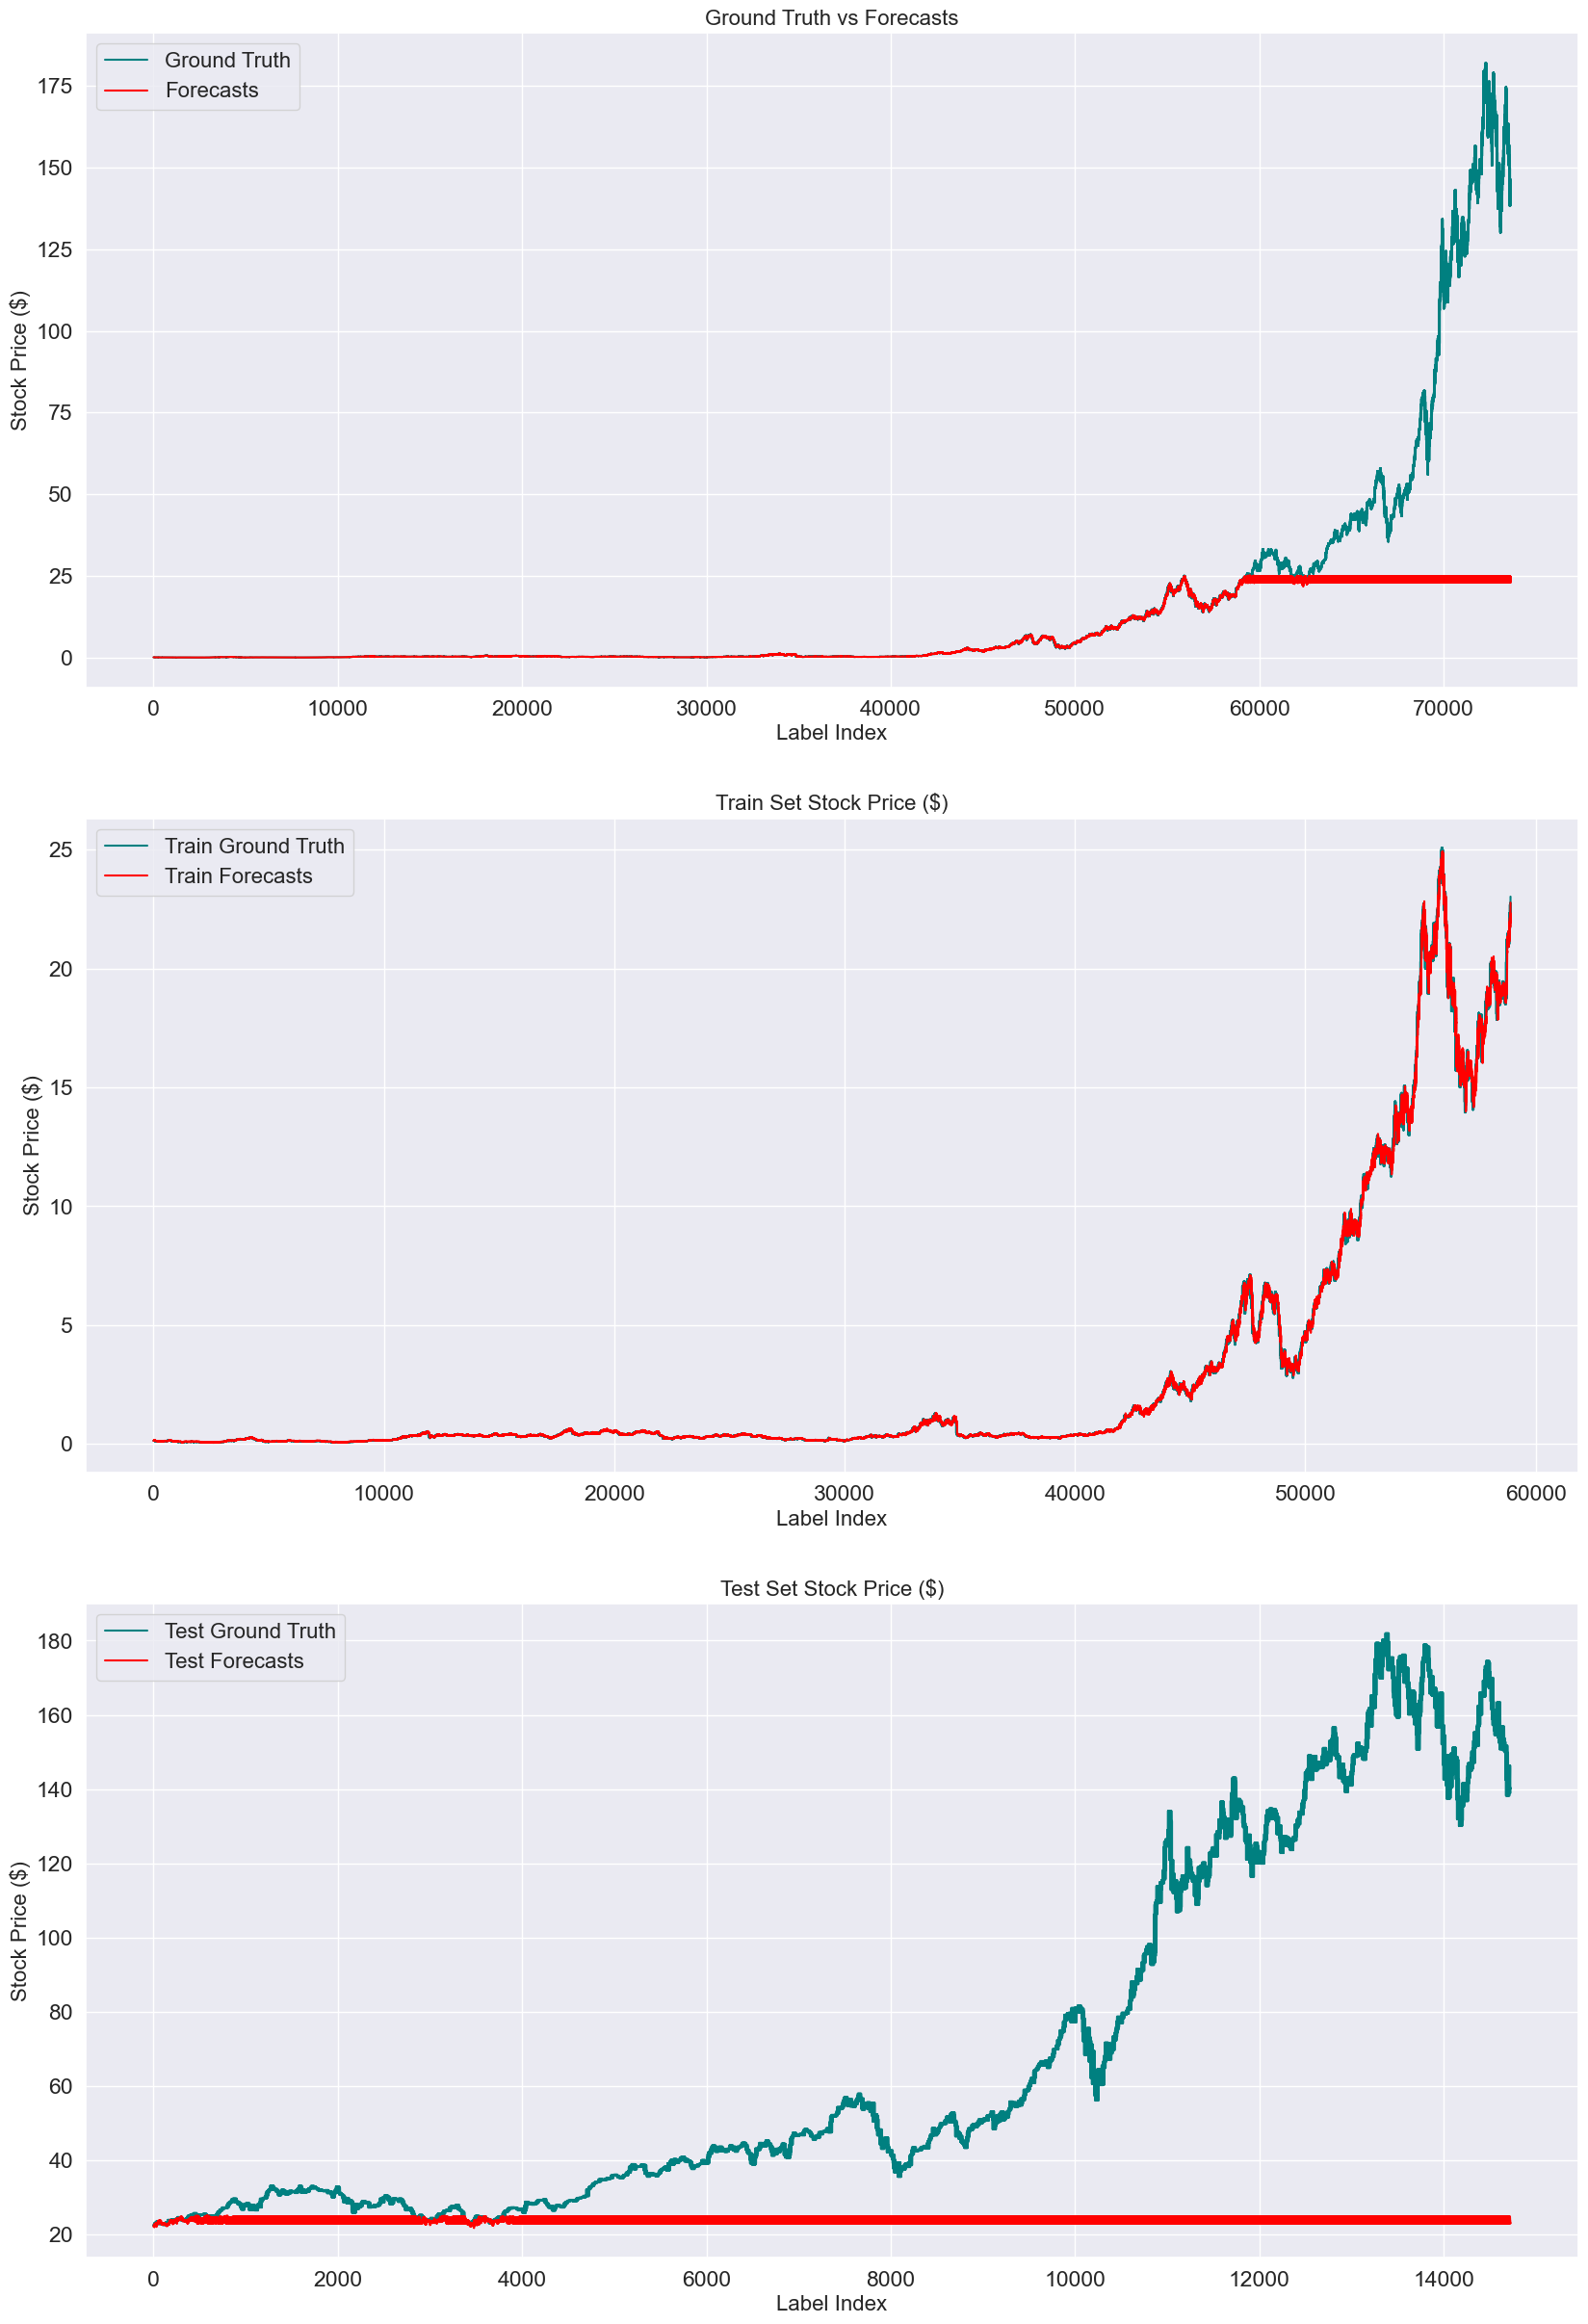

In [29]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = gbm_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [30]:
# Calling the function to evaluate the performance of the model
gbm_model_summary_df = evaluate_model_performance(model = gbm_model,
                                                  train_features = X_train,
                                                  train_labels = y_train,
                                                  test_features = X_test,
                                                  test_labels = y_test,
                                                  algorithm_name = "Gradient Boosting Machine")
# Displaying the evaluation summary
gbm_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Gradient Boosting Machine,0.05,0.47,0.07,44.06,0.03,4229.2,0.17,65.03


***
#### Light Gradient Boosting Machine (LightGBM)

In [31]:
# Calling the function to the build a forecasting pipeline
lgbm_model = build_pipeline(regressor = LGBMRegressor(random_state = 42),
                            support_multioutput = False,
                            train_features = X_train, 
                            train_labels = y_train)

# logging information to the log file
logging.info(msg = "Forecaster with Light Gradient Boosting Machine algorithm has been built")

# Displaying the architecture of the regressor
lgbm_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 MultiOutputRegressor(estimator=LGBMRegressor(random_state=42),
                                      n_jobs=-1))])

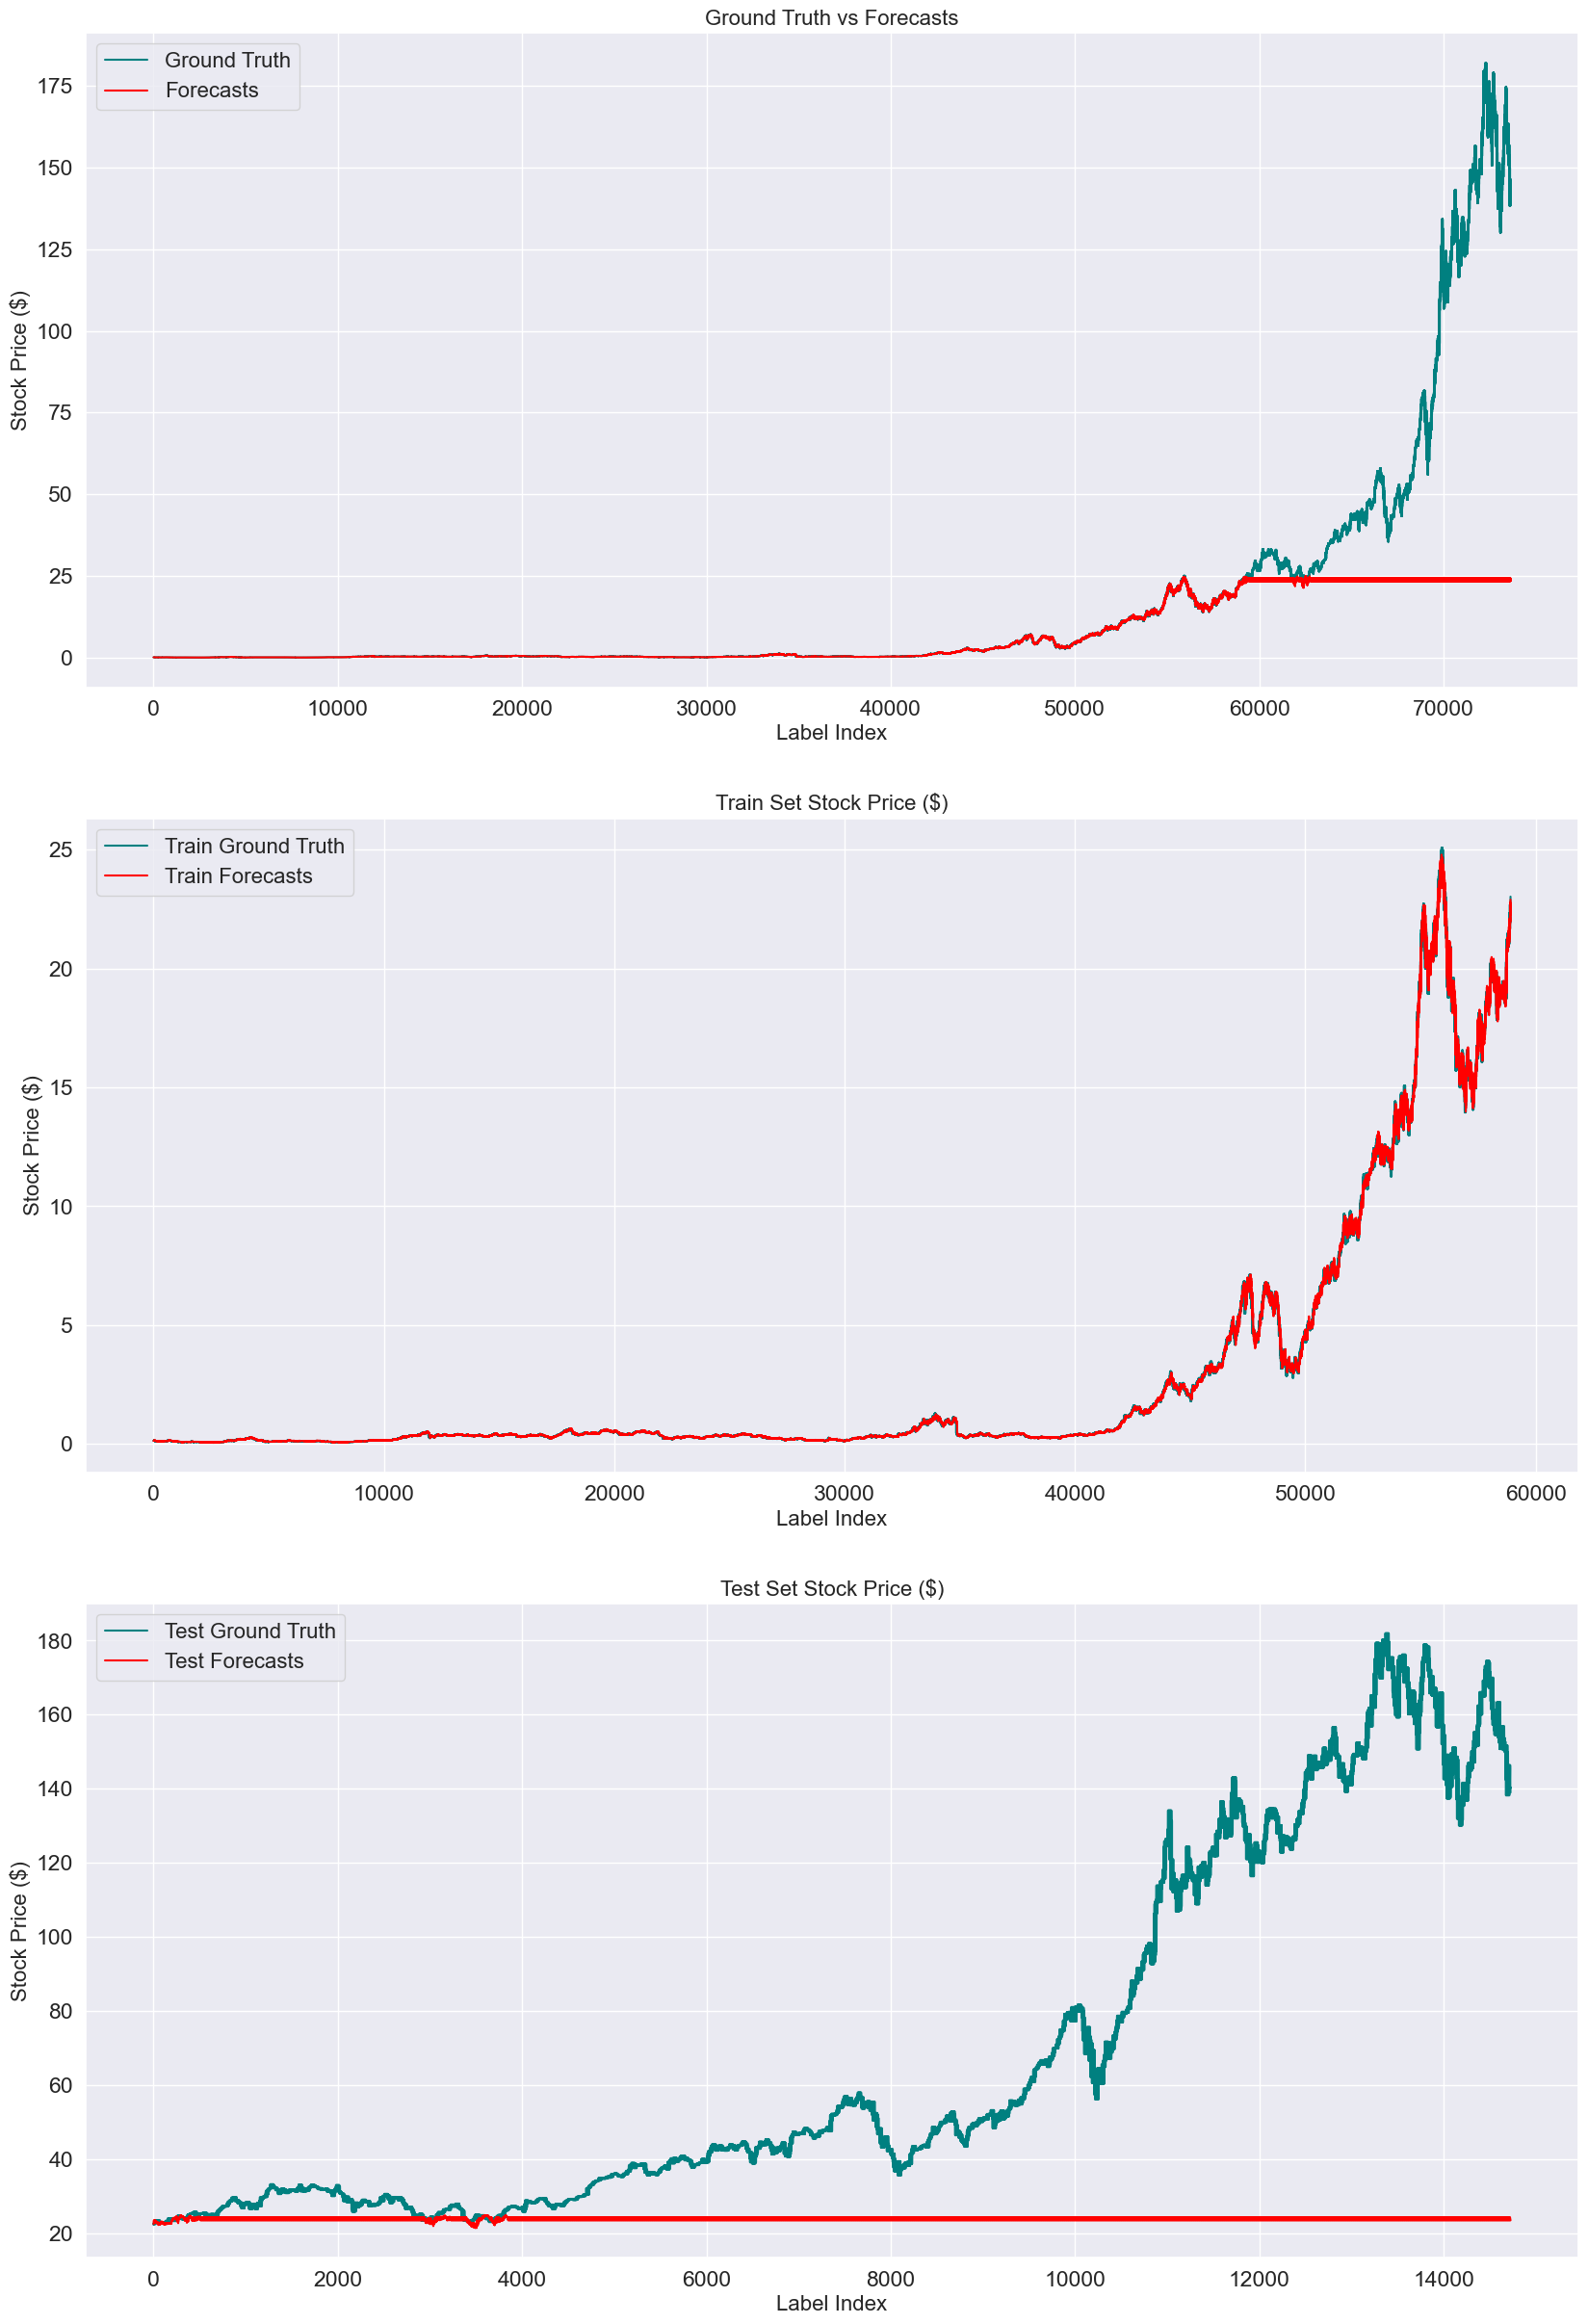

In [32]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = lgbm_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [33]:
# Calling the function to evaluate the performance of the model
lgbm_model_summary_df = evaluate_model_performance(model = lgbm_model,
                                                   train_features = X_train,
                                                   train_labels = y_train,
                                                   test_features = X_test,
                                                   test_labels = y_test,
                                                   algorithm_name = "Light Gradient Boosting Machine")
# Displaying the evaluation summary
lgbm_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Light Gradient Boosting Machine,0.04,0.47,0.05,43.84,0.01,4207.37,0.1,64.86


***
#### Extreme Gradient Boosting (XGBoost)

In [34]:
# Calling the function to the build a forecasting pipeline
xgbm_model = build_pipeline(regressor = XGBRegressor(n_jobs = -1, random_state = 42),
                            support_multioutput = False,
                            train_features = X_train, 
                            train_labels = y_train)

# logging information to the log file
logging.info(msg = "Forecaster with Extreme Gradient Boosting Machine algorithm has been built")

# Displaying the architecture of the regressor
xgbm_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             enable_categorical=False,
                                                             gamma=None,
                                                             gpu_id=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=42,
                                                             reg_alpha=None,
                                                             reg_lambda=None,
                                                             scale_pos_weight=None,
                                                             subsample=None,
                                                             tree_method=None,
                                                             validate_parameters=None,
                                                             verbosity=None),
                                      n_jobs=-1))])

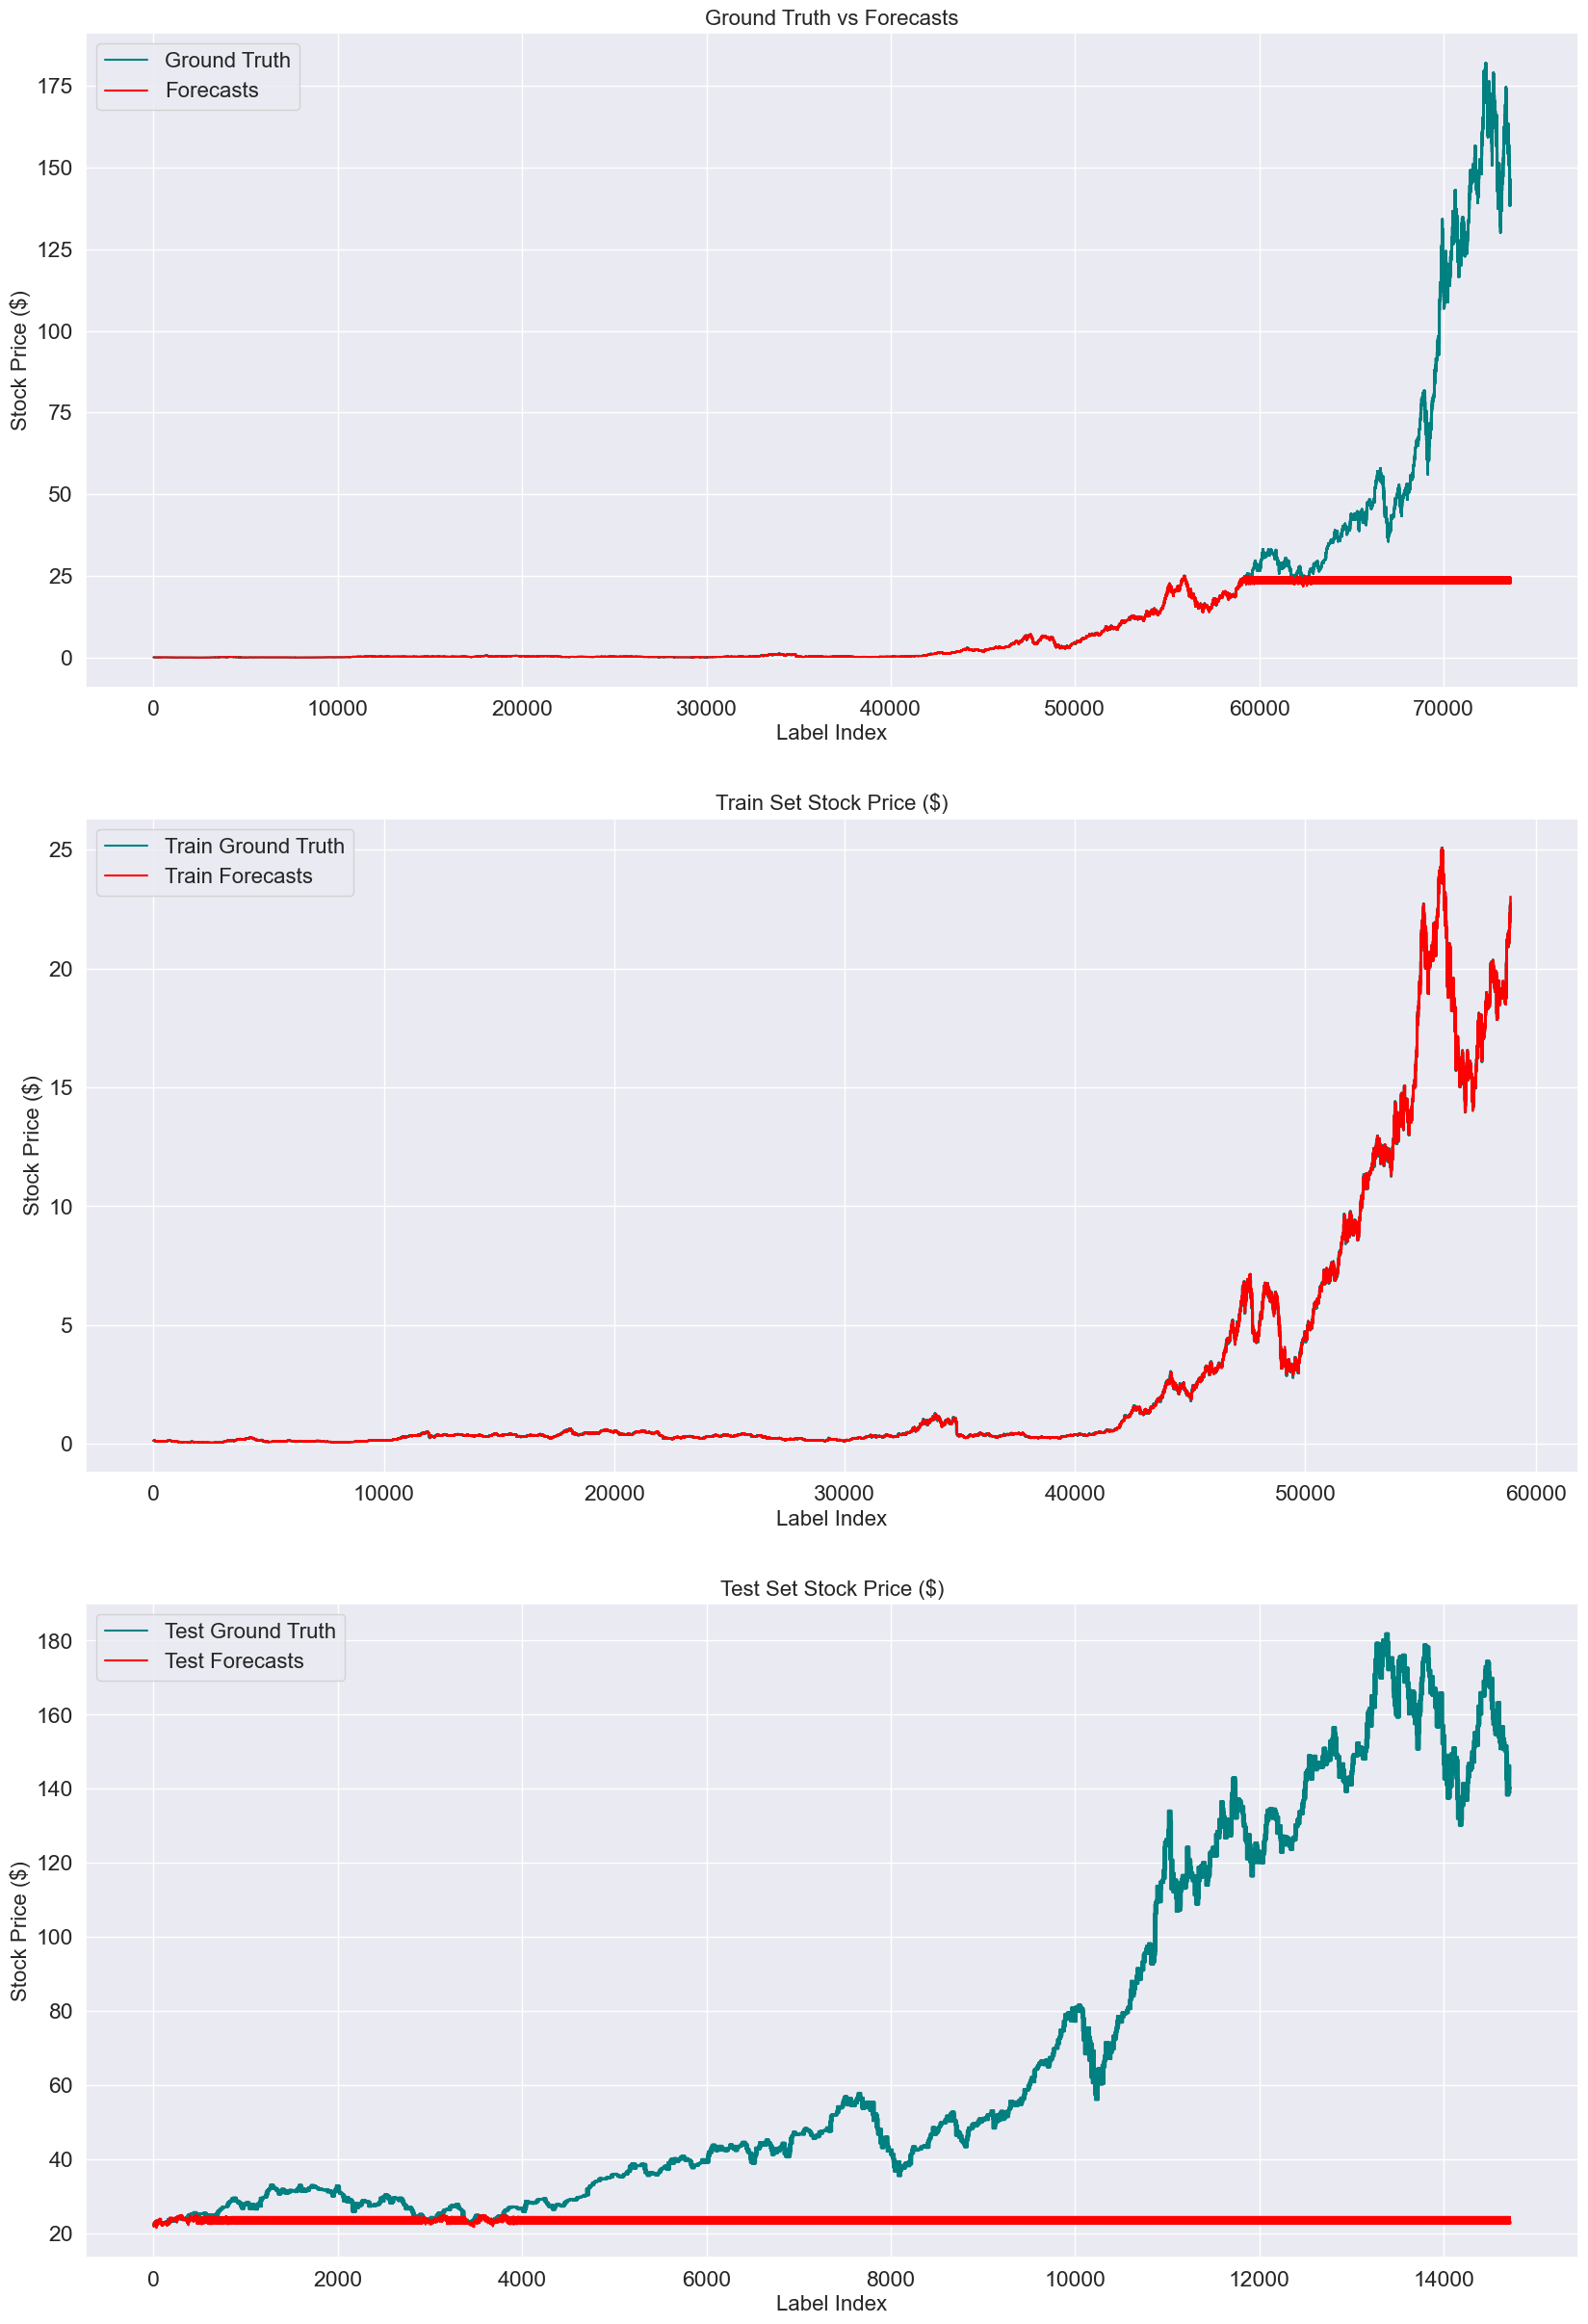

In [35]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = xgbm_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [36]:
# Calling the function to evaluate the performance of the model
xgbm_model_summary_df = evaluate_model_performance(model = xgbm_model,
                                                   train_features = X_train,
                                                   train_labels = y_train,
                                                   test_features = X_test,
                                                   test_labels = y_test,
                                                   algorithm_name = "Extreme Gradient Boosting Machine")
# Displaying the evaluation summary
xgbm_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Extreme Gradient Boosting Machine,0.03,0.48,0.02,44.54,0.0,4275.15,0.0,65.38


***
#### Adaptive Boosting (AdaBoost)

In [37]:
# Calling the function to the build a forecasting pipeline
ada_model = build_pipeline(regressor = AdaBoostRegressor(random_state = 42),
                           support_multioutput = False,
                           train_features = X_train, 
                           train_labels = y_train)

# logging information to the log file
logging.info(msg = "Forecaster with Adaptive Boosting algorithm has been built")

# Displaying the architecture of the regressor
ada_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 MultiOutputRegressor(estimator=AdaBoostRegressor(random_state=42),
                                      n_jobs=-1))])

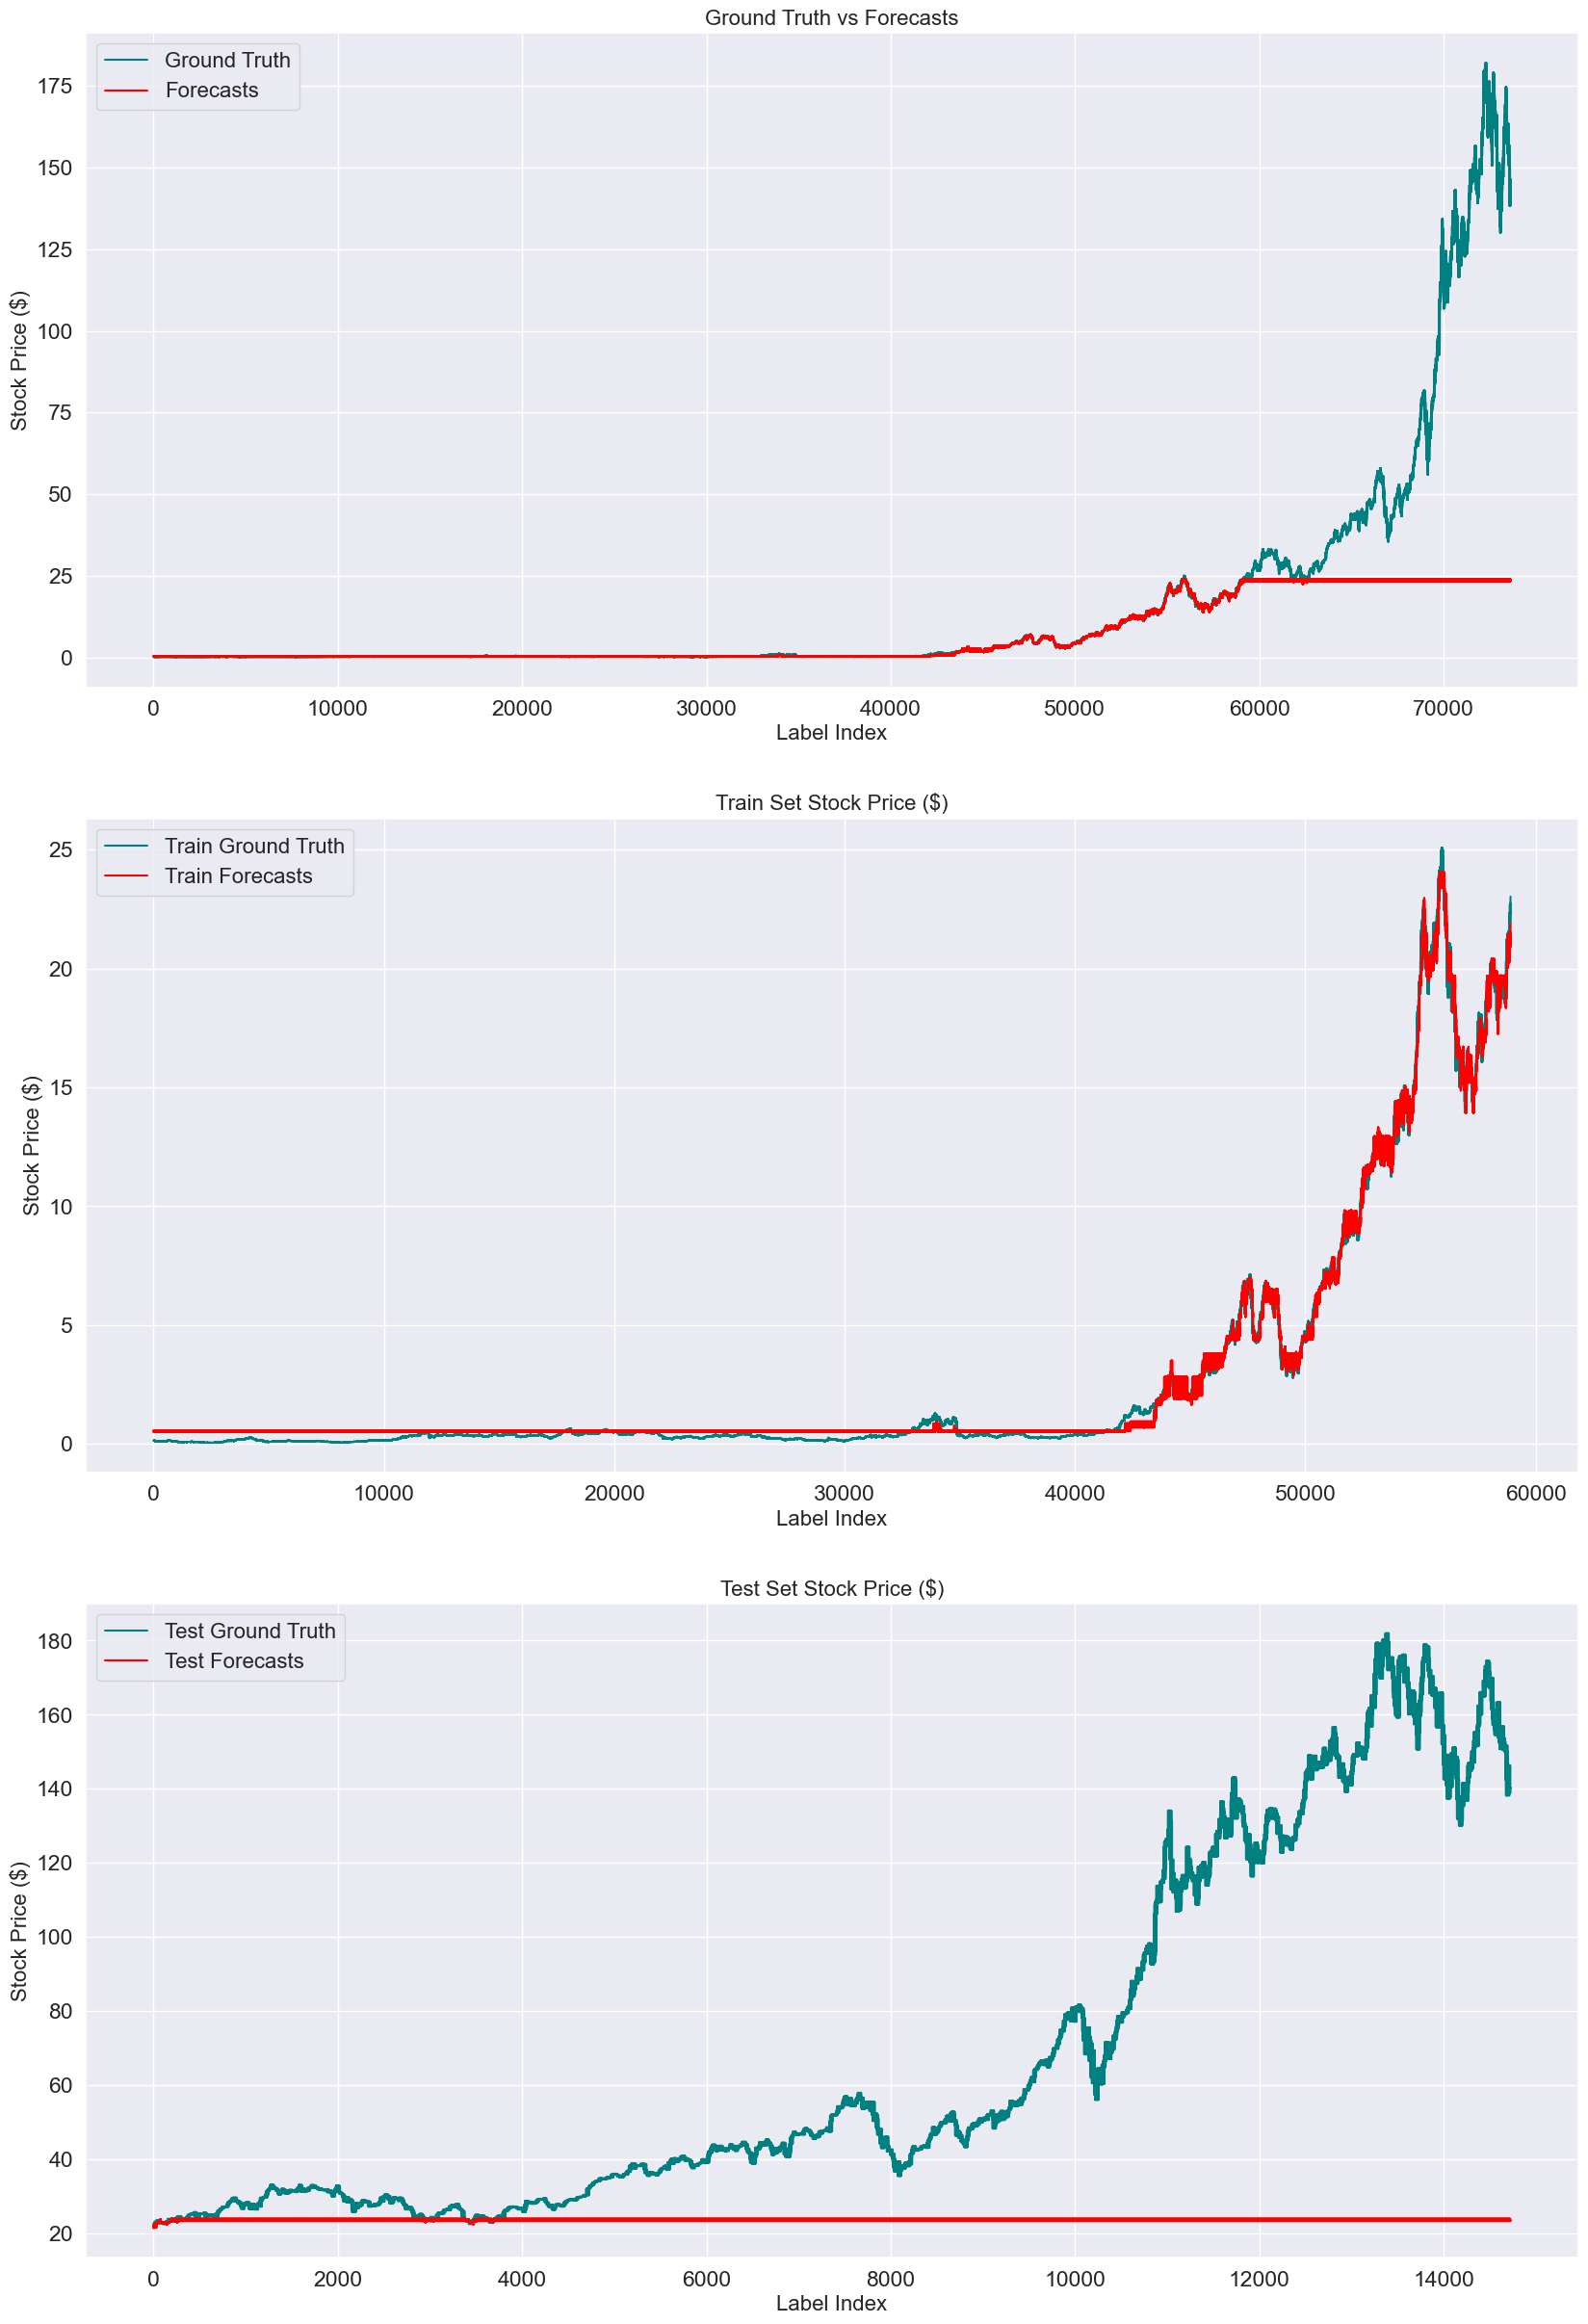

In [38]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = ada_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [39]:
# Calling the function to evaluate the performance of the model
ada_model_summary_df = evaluate_model_performance(model = ada_model,
                                                   train_features = X_train,
                                                   train_labels = y_train,
                                                   test_features = X_test,
                                                   test_labels = y_test,
                                                   algorithm_name = "Adaptive Boosting")
# Displaying the evaluation summary
ada_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Adaptive Boosting,1.08,0.47,0.29,44.01,0.13,4223.97,0.36,64.99


***
#### Category Boosting (CatBoost)

In [40]:
# Calling the function to the build a forecasting pipeline
cb_model = build_pipeline(regressor = CatBoostRegressor(loss_function = "MAE", eval_metric = "MAE", verbose = 0, objective = "MAE", random_state = 42),
                          support_multioutput = False,
                          train_features = X_train, 
                          train_labels = y_train)

# logging information to the log file
logging.info(msg = "Forecaster with Category Boosting algorithm has been built")

# Removing the folder
shutil.rmtree(path = "catboost_info")

# Displaying the architecture of the regressor
cb_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7f7dd03ad700>,
                                      n_jobs=-1))])

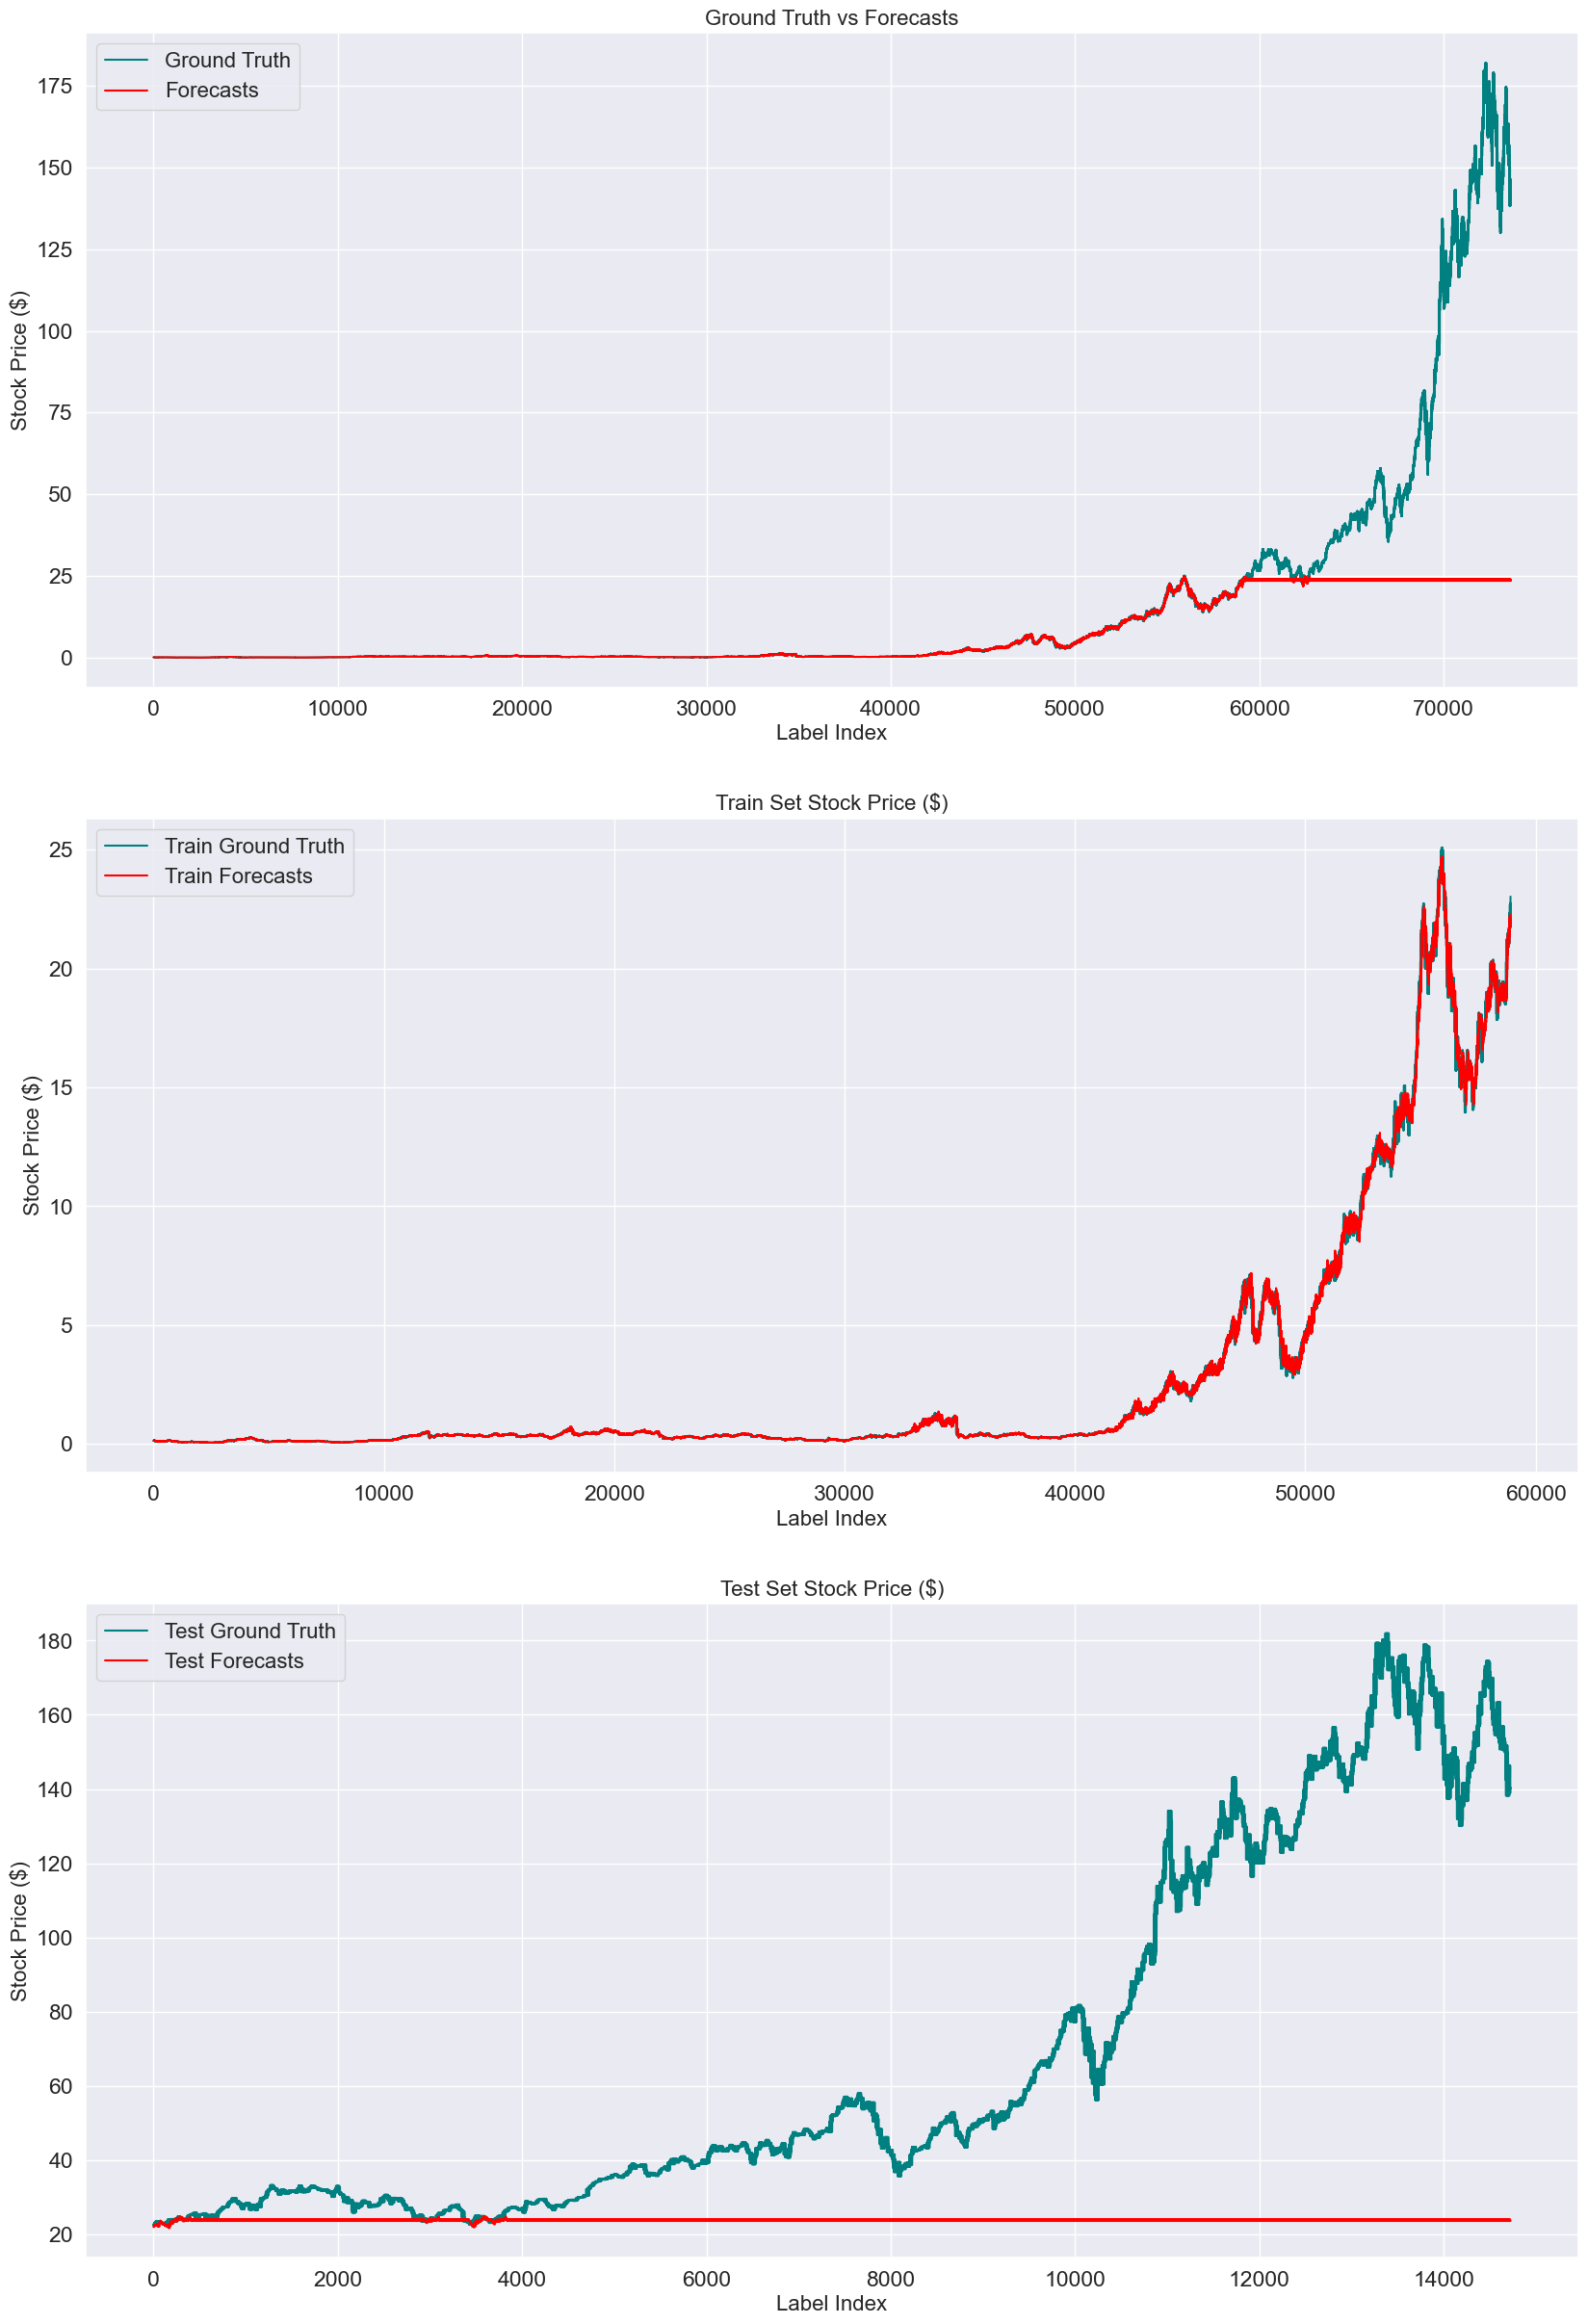

In [41]:
# Calling the function to visually compare forecasts to ground truths
plot_forecasts(model = cb_model,
               train_features = X_train,
               train_labels = y_train,
               test_features = X_test,
               test_labels = y_test)

In [42]:
# Calling the function to evaluate the performance of the model
cb_model_summary_df = evaluate_model_performance(model = cb_model,
                                                 train_features = X_train,
                                                 train_labels = y_train,
                                                 test_features = X_test,
                                                 test_labels = y_test,
                                                 algorithm_name = "Category Boosting")
# Displaying the evaluation summary
cb_model_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Category Boosting,0.04,0.47,0.08,43.96,0.04,4218.61,0.2,64.95


Let"s save the best model as a pickle object.

In [43]:
# Concatenating the evaluation summary of the models
models_summary_df = pd.concat(objs = [baseline_model_summary_df, lr_model_summary_df, br_model_summary_df, svm_model_summary_df, 
                                      knn_model_summary_df, dt_model_summary_df, rf_model_summary_df, gbm_model_summary_df, 
                                      lgbm_model_summary_df, xgbm_model_summary_df, ada_model_summary_df, cb_model_summary_df])

# Sorting the models based on the MAE and RMSE on the test set in ascending order
models_summary_df.sort_values(by = ["MAE Test", "RMSE Test"], inplace = True)

# Creating a dictionary of models
models_dict = {"Baseline": baseline_model,
               "Linear Regression": lr_model,
               "Bayesian Ridge": br_model,
               "Support Vector Machine": svm_model,
               "K Nearest Neighbors": knn_model,
               "Decision Tree": dt_model,
               "Random Forest": rf_model,
               "Gradient Boosting Machine": gbm_model,
               "Light Gradient Boosting Machine": lgbm_model,
               "Extreme Gradient Boosting Machine": xgbm_model,
               "Adaptive Boosting": ada_model,
               "Category Boosting": cb_model}

# Selecting the best model
best_model = models_dict.get(models_summary_df.index.tolist()[0])

# Saving the model as a pickle object
with open(file = "../Models/apple_ml_forecaster.pickle", mode = "wb") as pickled_model:
    pickle.dump(obj = best_model, file = pickled_model)
    
# logging information to the log file
logging.info(msg = f"Forecaster built with {models_summary_df.index.tolist()[0]} algorithm has been saved as a pickle object")

# Saving the modeling summary data frame as a csv file
models_summary_df.to_csv(path_or_buf = "../Data/Summary/apple_ml_forecasting_summary.csv", index_label = "Algorithm")

# Displaying the evaluation summary data frame
models_summary_df

,MAPE Train,MAPE Test,MAE Train,MAE Test,MSE Train,MSE Test,RMSE Train,RMSE Test
Linear Regression,0.05,0.02,0.09,1.82,0.05,9.72,0.22,3.12
Bayesian Ridge,0.05,0.02,0.09,1.82,0.05,9.71,0.22,3.12
Support Vector Machine,0.08,0.03,0.09,1.88,0.05,10.12,0.22,3.18
Light Gradient Boosting Machine,0.04,0.47,0.05,43.84,0.01,4207.37,0.10,64.86
Category Boosting,0.04,0.47,0.08,43.96,0.04,4218.61,0.20,64.95
Adaptive Boosting,1.08,0.47,0.29,44.01,0.13,4223.97,0.36,64.99
Gradient Boosting Machine,0.05,0.47,0.07,44.06,0.03,4229.20,0.17,65.03
K Nearest Neighbors,0.04,0.48,0.07,44.29,0.03,4252.42,0.17,65.21
Decision Tree,0.00,0.48,0.00,44.33,0.00,4253.28,0.00,65.22
Extreme Gradient Boosting Machine,0.03,0.48,0.02,44.54,0.00,4275.15,0.00,65.38
